# Initialization

In [0]:
!pip install catboost
!pip install hyperopt
!pip install pycaret
!pip install pyro-ppl
!pip install windrose
#!pip install -U pandas-profiling

In [0]:
# Imports
import hyperopt
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pyro
import pyro.distributions as dist
import re
import torch

# from pandas_profiling import ProfileReport
from catboost import CatBoostRegressor, Pool, cv
from pycaret.regression import *
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO, Predictive
from pyro.optim import Adam, ClippedAdam
from sklearn import linear_model, model_selection
from windrose import WindroseAxes

# Setup
# plt.style.use('ggplot')
%matplotlib inline
# plt.rcParams['figure.figsize'] = (16, 10)

In [1]:
# Upload data files
from google.colab import files
uploaded = files.upload()

# Functions

## General

In [0]:
def uv_to_ws(u, v):
    wind_speed = np.sqrt(np.square(u) + np.square(v))
    return wind_speed

def uv_to_wd(u, v, convention='from'):
    if convention == 'to':
        wind_direction = (180/math.pi) * np.arctan2(u, v)
    elif convention == 'from':
        wind_direction = 180 + (180/math.pi) * np.arctan2(u, v)
    else:
        raise ValueError('Invalid convention: use "from" or "to".')
    return wind_direction

def uv_to_wswd(u, v, convention='from'):
    wind_speed = uv_to_ws(u, v)
    wind_direction = uv_to_wd(u, v, convention)
    return wind_speed, wind_direction

def compute_delta_wd(wd_1, wd_2):
    x = np.cos(wd_1 - wd_2)
    y = np.sin(wd_1 - wd_2)
    temp_delta_wd = np.arctan2(y, x)
    return temp_delta_wd

def interpolate_wd(x, y1, delta, height):
    y2 = y1 + delta
    y3 = []
    for i in range(len(y1)):
        holder = np.abs(np.interp(height, x, [y1[i], y2[i]]))
        if holder > 360:
            y3.append(holder - 360)
        elif holder == 360:
            y3.append(0)
        else:
            y3.append(holder)
    return y3

def plot_windrose(wd, ws):
    ax = WindroseAxes.from_ax()
    ax.bar(wd, ws, normed=True, opening=1)
    ax.set_legend()

## Models

In [0]:
def compute_error(y_full, y_hat_full, hours):
    bias = np.empty(24)
    mae = np.empty(24)
    rmse = np.empty(24)
    r2 = np.empty(24)
    for i in range(1,25,1):
        y = y_full[hours==i]
        y_hat = y_hat_full[hours==i]
        bias[i-1] = np.mean(y - y_hat)
        mae[i-1] = np.mean(np.abs(y - y_hat))
        rmse[i-1] = np.sqrt(np.mean((y - y_hat)**2))
        r2[i-1] = max(0, 1 - np.sum((y - y_hat)**2) / np.sum((y - np.mean(y))**2))
    bias = bias.mean()
    mae = mae.mean()
    rmse = rmse.mean()
    r2 = r2.mean()
    sc = [bias, mae, rmse, r2]
    return sc

def compute_ss(sc_adv, sc_base):
    ss = [1 - (sc_adv[sc]/sc_base[sc]) for sc in range(len(sc_base))]
    return ss

def model_random(T, a=0, b=1):
    y_hat = np.random.uniform(a, b, T)
    return y_hat

def model_persistence(y_t, m, T):
    y_bar = np.mean(y_t[-m:])
    y_hat = np.asarray([y_bar for t in range(T)])
    return y_hat

def model_climatology(y_t, T):
    y_bar = np.mean(y_t)
    y_hat = np.asarray([y_bar for t in range(T)])
    return y_hat

def model_bayesianlr(X, y=None):
    N, M = X.shape
    lamb = 1
    mu = torch.zeros(M)
    sig = torch.diag(lamb*torch.eye(M))
    
    alpha = pyro.sample("alpha", dist.Normal(0., 0.1)) # Alpha prior (bias/intercept)
    beta = pyro.sample("beta", dist.Normal(mu, sig)) # Beta prior (coefficients)
    sigma = pyro.sample("sigma", dist.HalfCauchy(1.)) # Variance prior (only positive)
    with pyro.plate("data", N):
        y = pyro.sample("y", dist.Normal(alpha + X.matmul(beta), sigma), obs=y)
    return y

def model_bnnet(X, y=None):
    # Initialize the neural network from PyTorch 
    torch_model = FFNN(n_in=X.shape[1], n_hidden=5, n_out=1) 
    
    # Convert the PyTorch neural net into a Pyro model with priors
    priors = {} # Priors for the neural model
    for name, par in torch_model.named_parameters():     # Loop over all parameters
        priors[name] = dist.Normal(torch.zeros(*par.shape),
                                   torch.ones(*par.shape)).independent(1) # N(0, 1) prior
        
    # Make this model and these priors a Pyro model
    bayesian_model = pyro.random_module('bayesian_model', torch_model, priors) 
    sampled_model = bayesian_model() # Initialize the model
    
    # The generative process
    with pyro.plate("observations"):
        prediction_mean = sampled_model(X).squeeze(-1) # Feed-forward X through the nnet
        y = pyro.sample("obs", dist.Normal(prediction_mean, 0.01), obs=y)
        
    return y

In [0]:
def compute_error2(y_full, y_hat_full, hours):
    bias = np.empty(24)
    mae = np.empty(24)
    rmse = np.empty(24)
    r2 = np.empty(24)
    for i in range(1,25,1):
        y = y_full[hours==i]
        y_hat = y_hat_full[hours==i]
        bias[i-1] = np.mean(y - y_hat)
        mae[i-1] = np.mean(np.abs(y - y_hat))
        rmse[i-1] = np.sqrt(np.mean((y - y_hat)**2))
        r2[i-1] = max(0, 1 - np.sum((y - y_hat)**2) / np.sum((y - np.mean(y))**2))
    sc = [bias, mae, rmse, r2]
    return sc

In [0]:
def rlr_validate(X, y, lambdas, cvf=10):
    """ Validate regularized linear regression model using 'cvf'-fold cross validation.
        Find the optimal lambda (minimizing validation error) from 'lambdas' list.
        The loss function computed as RMSE on validation set.
        Function returns: MSE averaged over 'cvf' folds, optimal value of lambda,
        average weight values for all lambdas, RMSE train&validation errors for all lambdas.
        The cross validation splits are standardized based on the mean and standard
        deviation of the training set when estimating the regularization strength.
        
        Parameters:
        X       training data set
        y       vector of values
        lambdas vector of lambda values to be validated
        cvf     number of crossvalidation folds     
        
        Returns:
        opt_val_err         validation error for optimum lambda
        opt_lambda          value of optimal lambda
        mean_w_vs_lambda    weights as function of lambda (matrix)
        train_err_vs_lambda train error as function of lambda (vector)
        test_err_vs_lambda  test error as function of lambda (vector)
    """
    CV = model_selection.KFold(cvf, shuffle=False)
    M = X.shape[1]
    w = np.empty((M, cvf, len(lambdas)))
    train_error = np.empty((cvf, len(lambdas)))
    test_error = np.empty((cvf, len(lambdas)))
    f = 0
    y = y.squeeze()

    for train_index, test_index in CV.split(X, y):
        X_train = X[train_index]
        y_train = y[train_index]
        X_test = X[test_index]
        y_test = y[test_index]
        
        # Precompute terms
        Xty = X_train.T @ y_train
        XtX = X_train.T @ X_train

        for l in range(0, len(lambdas)):
            # Compute parameters for current value of lambda and current CV fold
            lambdaI = lambdas[l] * np.eye(M)
            lambdaI[0,0] = 0 # remove bias regularization
            w[:,f,l] = np.linalg.solve(XtX + lambdaI, Xty).squeeze() # get weights
            
            # Evaluate training and test performance with RMSE
            train_error[f,l] = \
                np.sqrt(np.power(y_train - X_train @ w[:,f,l].T, 2).mean(axis=0))
            test_error[f,l] = \
                np.sqrt(np.power(y_test - X_test @ w[:,f,l].T, 2).mean(axis=0))
    
        f += 1

    opt_val_err = np.min(np.mean(test_error,axis=0))
    opt_lambda = lambdas[np.argmin(np.mean(test_error,axis=0))]
    train_err_vs_lambda = np.mean(train_error,axis=0)
    test_err_vs_lambda = np.mean(test_error,axis=0)
    mean_w_vs_lambda = np.squeeze(np.mean(w,axis=1))
    
    return opt_val_err, opt_lambda, mean_w_vs_lambda, train_err_vs_lambda,test_err_vs_lambda

def train_neural_net(model, loss_fn, X, y, n_replicates=3, max_iter=10000, tolerance=1e-6):
    """
    Train a neural network with PyTorch based on a training set consisting of
    observations X and target y. The model and loss_fn inputs define the
    architecture to train and the cost-function update the weights based on,
    respectively.
        
    Args:
        model:          A function handle to make a torch.nn.Sequential.
        loss_fn:        A torch.nn-loss, e.g.  torch.nn.BCELoss() for binary 
                        binary classification, torch.nn.CrossEntropyLoss() for
                        multiclass classification, or torch.nn.MSELoss() for
                        regression.
        n_replicates:   An integer specifying number of replicates to train,
                        the neural network with the lowest loss is returned.
        max_iter:       An integer specifying the maximum number of iterations
                        to do (default 10000).
        tolerance:     A float describing the tolerance/convergence criterion
                        for minimum relative change in loss (default 1e-6)
                        
    Returns:
        A list of three elements:
            best_net:       A trained torch.nn.Sequential that had the lowest 
                            loss of the trained replicates
            final_loss:     An float specifying the loss of best performing net
            learning_curve: A list containing the learning curve of the best net.
    """

    # Specify maximum number of iterations for training
    logging_frequency = 1000 # display the loss every 1000th iteration
    best_final_loss = 1e100

    for r in range(n_replicates):
        print('\n\tReplicate: {}/{}'.format(r + 1, n_replicates))
        # Make a new net (calling model() makes a new initialization of weights) 
        net = model()
        
        # Initialize weights based on limits that scale with number of in- and
        # outputs to the layer, increasing the chance that we converge to 
        # a good solution
        torch.nn.init.xavier_uniform_(net[0].weight)
        torch.nn.init.xavier_uniform_(net[-1].weight)
                     
        # Set optimizer
        optimizer = torch.optim.Adam(net.parameters())
        
        # Train the network while displaying and storing the loss
        print('\t\t{}\t{}\t\t\t{}'.format('Iter', 'Loss','Rel. loss'))
        learning_curve = [] # setup storage for loss at each step
        old_loss = 1e6
        for i in range(max_iter):
            y_est = net(X) # forward pass, predict target on training set
            y = torch.squeeze(y)
            y_est = torch.squeeze(y_est)
            loss = loss_fn(y_est, y) # determine loss
            loss_value = loss.data.numpy() # get numpy array instead of tensor
            learning_curve.append(loss_value) # record loss for later display
            
            # Convergence check, see if the percentual loss decrease is within
            # tolerance:
            p_delta_loss = np.abs(loss_value-old_loss)/old_loss
            if p_delta_loss < tolerance: break
            old_loss = loss_value
            
            # Display loss with some frequency:
            if (i != 0) & ((i+1) % logging_frequency == 0):
                print_str = '\t\t' + str(i+1) + '\t' + str(loss_value) + '\t' + \
                str(p_delta_loss)
                print(print_str)

            # Backpropagation of loss and optimize weights 
            optimizer.zero_grad(); loss.backward(); optimizer.step()
            
            
        # Display final loss
        print('\t\tFinal loss:')
        print_str = '\t\t' + str(i+1) + '\t' + str(loss_value) + '\t' + str(p_delta_loss)
        print(print_str)
        
        if loss_value < best_final_loss: 
            best_net = net
            best_final_loss = loss_value
            best_learning_curve = learning_curve
        
    # Return the best curve along with its final loss and learing curve
    return best_net, best_final_loss, best_learning_curve

def train_reg_nn(model, loss_fn, X, y, lambdas, n_replicates=3, 
                     max_iter=10000,
                     tolerance=1e-6):
    """
    Train a neural network with PyTorch based on a training set consisting of
    observations X and target y. The model and loss_fn inputs define the
    architecture to train and the cost-function update the weights based on,
    respectively.
        
    Args:
        model:          A function handle to make a torch.nn.Sequential.
        loss_fn:        A torch.nn-loss, e.g.  torch.nn.BCELoss() for binary 
                        binary classification, torch.nn.CrossEntropyLoss() for
                        multiclass classification, or torch.nn.MSELoss() for
                        regression.
        n_replicates:   An integer specifying number of replicates to train,
                        the neural network with the lowest loss is returned.
        lambdas:        Array of regularization parameters.
        max_iter:       An integer specifying the maximum number of iterations
                        to do (default 10000).
        tolerance:     A float describing the tolerance/convergence criterion
                        for minimum relative change in loss (default 1e-6)
                        
    Returns:
        A list of three elements:
            best_net:       A trained torch.nn.Sequential that had the lowest 
                            loss of the trained replicates
            final_loss:     An float specifying the loss of best performing net
            learning_curve: A list containing the learning curve of the best net.
    """

    # Specify maximum number of iterations for training
    logging_frequency = 1000 # display the loss every 1000th iteration
    best_final_loss = 1e100

    for l, ld in enumerate(lambdas):
        print('\n\Lambdas: {}/{}'.format(l + 1, len(lambdas)))

        # Make a new net (calling model() makes a new initialization of weights) 
        net = model()
        
        # Initialize weights based on limits that scale with number of in- and
        # outputs to the layer, increasing the chance that we converge to 
        # a good solution
        torch.nn.init.xavier_uniform_(net[0].weight)
        torch.nn.init.xavier_uniform_(net[-1].weight)
                     
        # Set optimizer
        optimizer = torch.optim.Adam(net.parameters(), weight_decay=ld)
        
        # Train the network while displaying and storing the loss
        print('\t\t{}\t{}\t\t\t{}'.format('Iter', 'Loss','Rel. loss'))
        learning_curve = [] # setup storage for loss at each step
        old_loss = 1e6
        for i in range(max_iter):
            y_est = net(X) # forward pass, predict target on training set
            y = torch.squeeze(y)
            y_est = torch.squeeze(y_est)
            loss = loss_fn(y_est, y) # determine loss
            loss_value = loss.data.numpy() # get numpy array instead of tensor
            learning_curve.append(loss_value) # record loss for later display
            
            # Convergence check, see if the percentual loss decrease is within
            # tolerance:
            p_delta_loss = np.abs(loss_value-old_loss)/old_loss
            if p_delta_loss < tolerance: break
            old_loss = loss_value
            
            # Display loss with some frequency:
            if (i != 0) & ((i+1) % logging_frequency == 0):
                print_str = '\t\t' + str(i+1) + '\t' + str(loss_value) + '\t' + \
                str(p_delta_loss)
                print(print_str)

            # Backpropagation of loss and optimize weights 
            optimizer.zero_grad(); loss.backward(); optimizer.step()
            
            
        # Display final loss
        print('\t\tFinal loss:')
        print_str = '\t\t' + str(i+1) + '\t' + str(loss_value) + '\t' + str(p_delta_loss)
        print(print_str)
        
        if loss_value < best_final_loss: 
            best_net = net
            best_final_loss = loss_value
            best_learning_curve = learning_curve
            best_lambda = ld
        
    # Return the best curve along with its final loss and learing curve
    return best_net, best_final_loss, best_learning_curve, best_lambda



In [0]:
class FFNN(torch.nn.Module):
    def __init__(self, n_in, n_hidden, n_out):
        super(FFNN, self).__init__()
        
        # Architecture
        self.in_layer = torch.nn.Linear(n_in, n_hidden)
        self.h_layer = torch.nn.Linear(n_hidden, n_hidden)
        self.out_layer = torch.nn.Linear(n_hidden, n_out)
        
        # Activation functions
        self.tanh = torch.nn.Tanh()
        
    def forward(self, X):
        # Forward pass
        X = self.tanh(self.in_layer(X))
        X = self.tanh(self.h_layer(X))
        X = self.tanh(self.h_layer(X))
        X = self.tanh(self.h_layer(X))
        X = self.out_layer(X)
        
        return X

# Driver

## Data preparation

In [0]:
# File names
file_names = ['TrainData1.csv',
              'TrainData2.csv',
              'TrainData3.csv',
              'TrainData4.csv',
              'WeatherForecastInput1.csv',
              'WeatherForecastInput2.csv',
              'WeatherForecastInput3.csv',
              'WeatherForecastInput4.csv',
              'ForecastTemplate1.csv',
              'ForecastTemplate2.csv',
              'ForecastTemplate3.csv',
              'ForecastTemplate4.csv',
              'Solution1.csv',
              'Solution2.csv',
              'Solution3.csv',
              '31761-Holmsbu_United-stage1.csv',
              '31761-Holmsbu_United-stage2.csv',
              '31761-Holmsbu_United-stage3.csv']

# Select case
i = 3 # stage 1, 2, 3 or 4

# Import data
train_raw = pd.read_csv(file_names[i - 1], index_col=0, parse_dates=True)
weather_raw = pd.read_csv(file_names[i + 3], index_col=0, parse_dates=True)
template = pd.read_csv(file_names[i + 7], index_col=0, parse_dates=True)
solution = pd.read_csv(file_names[i + 11], index_col=0, parse_dates=True) # comment if i=4
#bid = pd.read_csv(file_names[i + 14], index_col=0, parse_dates=True) # comment if i=4

In [0]:
# Count nans
train_raw.isna().sum()

POWER    459
U10        1
V10        1
U100       1
V100       1
dtype: int64

In [0]:
# Drop columns with nans
train_raw.dropna(inplace=True) # only first row full of nan

In [0]:
# Copy to keep raw data
train = train_raw.copy()
weather = weather_raw.copy()

In [0]:
# Convert wind components to speed and direction
train['ws_10'], train['wd_10'] = uv_to_wswd(train['U10'], train['V10'])
train['ws_100'], train['wd_100'] = uv_to_wswd(train['U100'], train['V100'])
weather['ws_10'], weather['wd_10'] = uv_to_wswd(weather['U10'], weather['V10'])
weather['ws_100'], weather['wd_100'] = uv_to_wswd(weather['U100'], weather['V100'])

In [0]:
# Drop u and v components
train.drop(columns=['U10', 'V10', 'U100', 'V100'], inplace=True)
weather.drop(columns=['U10', 'V10', 'U100', 'V100'], inplace=True)

In [0]:
# Copy for data viz
train_dataviz = train.copy()

## Features

In [0]:
# Select measurements to keep and select month
m_at_10 = False
m_at_70 = True # always keep
m_at_100 = False
m_square = False # only lr, rlr, rr, and blr
m_cube = False # only lr, rlr, rr, and blr

In [0]:
# Calculate wind direction at 70m (interpolated between 10m and 100m)
delta_wd_train = compute_delta_wd(train['wd_10'], train['wd_100'])
delta_wd_weather = compute_delta_wd(weather['wd_10'], weather['wd_100'])
train['wd_70'] = interpolate_wd([10, 100], train['wd_10'], delta_wd_train, 70)
weather['wd_70'] = interpolate_wd([10, 100], weather['wd_10'], delta_wd_weather, 70)

In [0]:
# Calculate wind speed at 70m with power law
α_train = np.log(train['ws_100'] / train['ws_10']) / np.log(100 / 10)
α_weather = np.log(weather['ws_100'] / weather['ws_10']) / np.log(100 / 10)
train['ws_70'] = train['ws_10'] * (70/10) ** α_train
weather['ws_70'] = weather['ws_10'] * (70/10) ** α_weather

In [0]:
# New variables as squared and cubed measurements for linear regression
#70
train['ws_70^2'] = train['ws_70']*train['ws_70']
train['ws_70^3'] = train['ws_70']*train['ws_70']*train['ws_70']
weather['ws_70^2'] = weather['ws_70']*weather['ws_70']
weather['ws_70^3'] = weather['ws_70']*weather['ws_70']*weather['ws_70']
#10
train['ws_10^2'] = train['ws_10']*train['ws_10']
train['ws_10^3'] = train['ws_10']*train['ws_10']*train['ws_10']
weather['ws_10^2'] = weather['ws_10']*weather['ws_10']
weather['ws_10^3'] = weather['ws_10']*weather['ws_10']*weather['ws_10']
#100
train['ws_100^2'] = train['ws_100']*train['ws_100']
train['ws_100^3'] = train['ws_100']*train['ws_100']*train['ws_100']
weather['ws_100^2'] = weather['ws_100']*weather['ws_100']
weather['ws_100^3'] = weather['ws_100']*weather['ws_100']*weather['ws_100']

In [0]:
# Extract month and hour from datetime index
train['month'] = train.index.month
train['hour'] = train.index.hour + 1
weather['month'] = weather.index.month
weather['hour'] = weather.index.hour + 1

In [0]:
# Create list with columns to drop based on regex
columns_to_drop = []
if not m_at_10:
    columns_to_drop.append(
        [i for i in train.columns.values if re.search(r'_10[^ ]*$', i)])
if not m_at_70:
    columns_to_drop.append(
        [i for i in train.columns.values if re.search(r'_70[^ ]*$', i)])
if not m_at_100:
    columns_to_drop.append(
        [i for i in train.columns.values if re.search(r'_100[^ ]*$', i)])
if not m_square:
    columns_to_drop.append(
        [i for i in train.columns.values if re.search(r'[^ ]2$', i)])
if not m_cube:
    columns_to_drop.append(
        [i for i in train.columns.values if re.search(r'[^ ]3$', i)])

# Flatten
columns_to_drop = [item for sublist in columns_to_drop for item in sublist]

In [0]:
# Drop unselected columns
train.drop(columns=columns_to_drop, inplace=True)
weather.drop(columns=columns_to_drop, inplace=True)

In [0]:
train.head()

POWER       wd_70      ws_70  month  hour
TIMESTAMP                                                        
2015-01-01 03:00:00  0.666693  228.822975  11.063317      1     4
2015-01-01 06:00:00  0.937501  225.324704  11.884215      1     7
2015-01-01 09:00:00  0.935002  231.504966  13.014957      1    10
2015-01-01 12:00:00  0.912940  233.641576  14.024736      1    13
2015-01-01 15:00:00  0.971080  223.686157  14.618956      1    16

In [0]:
# One-hot-encoding variables and divide into y and X
X = pd.get_dummies(train, columns=['month', 'hour'])
X_predict = pd.get_dummies(weather, columns=['month', 'hour'])

In [0]:
X.head()

POWER       wd_70      ws_70  ...  hour_22  hour_23  hour_24
TIMESTAMP                                             ...                           
2015-01-01 03:00:00  0.666693  228.822975  11.063317  ...        0        0        0
2015-01-01 06:00:00  0.937501  225.324704  11.884215  ...        0        0        0
2015-01-01 09:00:00  0.935002  231.504966  13.014957  ...        0        0        0
2015-01-01 12:00:00  0.912940  233.641576  14.024736  ...        0        0        0
2015-01-01 15:00:00  0.971080  223.686157  14.618956  ...        0        0        0

[5 rows x 39 columns]

In [0]:
# Adjust X_predict to include all months
col_names = X.columns.difference(X_predict.columns)
temp = pd.DataFrame(np.zeros((X_predict.shape[0], len(col_names)), dtype=int),
                    index=X_predict.index,
                    columns=col_names)
X_predict = pd.concat([X_predict, temp], axis=1)
X_predict = X_predict[X.columns[1:]]
attributes = X_predict.columns.values.tolist()

In [0]:
X_predict.head()

wd_70      ws_70  month_1  ...  hour_22  hour_23  hour_24
TIMESTAMP                                            ...                           
2018-02-01 01:00:00  246.414374  13.078303        0  ...        0        0        0
2018-02-01 02:00:00  247.927757  13.117515        0  ...        0        0        0
2018-02-01 03:00:00  246.470508  12.442725        0  ...        0        0        0
2018-02-01 04:00:00  237.838691  12.082991        0  ...        0        0        0
2018-02-01 05:00:00  236.585199  12.352900        0  ...        0        0        0

[5 rows x 38 columns]

In [0]:
# Convert to np array and drop target variable from X
y = X.POWER.values
X.drop(columns=['POWER'], inplace=True)
X = X.values
X_predict = X_predict.values

In [0]:
# Standardize the data set based on moments
p_c = X.shape[1] - (24 + 12) # ignore dummy variables
mu = np.mean(X[:, 0:p_c], 0)
sigma = np.std(X[:, 0:p_c], 0)
X[:, 0:p_c] = (X[:, 0:p_c] - mu) / sigma
X_predict[:, 0:p_c] = (X_predict[:, 0:p_c] - mu) / sigma

In [0]:
# Add column of ones (for regularized linear regression)
X_ones = np.concatenate((np.ones((X.shape[0], 1)), X), 1)
X_predict_ones = np.concatenate((np.ones((X_predict.shape[0], 1)), X_predict), 1)
attributes.insert(0, 'Offset')

In [0]:
# # Permutation for trained NN w/o regularization
# perm = np.random.permutation(len(y))
# X_perm = X[perm, :]
# y_perm = y[perm]

In [0]:
# # Simple train/test split
# train_perc = 1 # percentage of training data
# split_point = int(train_perc*len(y))
# X_train = X[:split_point,:]
# X_test = X[split_point:,:]
# y_train = y[:split_point]
# y_test = y[split_point:]

In [0]:
# Solutions
y_sol = solution.POWER

## Models

### General Parameters

In [0]:
# General parameters
T = X_predict.shape[0] # hours ahead
m = 3 # persistence
N, M = X.shape
#N_2, M_2 = X_ones.shape
print('Total observations: %i' % N)
print('Forecast observations: %i' %T)
print('m observations used: %i' %m)
print('Features: %i' % M)

# Cross-validation
K = 10
cv = model_selection.KFold(n_splits=K, shuffle=True)

# Values of lambda (for regularization)
lambdas = np.power(10.,range(-5,12))

Total observations: 26590
Forecast observations: 672
m observations used: 3
Features: 38


### Baseline Models

In [0]:
# Random, persistence and climatology
y_hat_random = model_random(T)
y_hat_pers = model_persistence(y, m, T) # m-average per hour
y_hat_clima = model_climatology(y, T) # add a forgetting factor to make it better

### Unregularized Linear Regression

In [0]:
# Initialize arrays
test_error_lr = np.empty((K, 1))
w_lr = np.empty((M + 1, K))

In [0]:
# Run CV of unregularized linear regression (no standardization!)
k = 0
for train_index, test_index in cv.split(X, y):
    
    # Extract training and test set for current CV fold
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]
    y_test_n = y_test.shape[0]

    # Fit model
    regr = linear_model.LinearRegression(fit_intercept=True)
    regr.fit(X_train, y_train)

    # Obtain estimates
    y_hat_lr = regr.predict(X_test) # estimates
    estimates = [0.975 if y_hat > 1 else 0.025 if y_hat < 0 else y_hat \
                 for y_hat in y_hat_lr] # truncate
    y_hat_lr = np.array(estimates)

    # Save coefficients
    w_lr[0, k] = regr.intercept_.squeeze()
    w_lr[1:, k] = regr.coef_.squeeze()

    # Compute error
    test_error_lr[k] = \
        np.sqrt(np.square(y_test - y_hat_lr).sum(axis=0) / y_test_n)
    
    k += 1

In [0]:
# Use weights
weights = w_lr.mean(axis=1)

# Estimate forecast
y_hat_lr = weights[1:] @ X_predict.T + weights[0]

# Truncate if over 1
estimates = [0.975 if y_hat > 1 else 0.025 if y_hat < 0 else y_hat for y_hat in y_hat_lr]
y_hat_lr = np.array(estimates)

In [0]:
# Coefficients
for i, coef in enumerate(weights):
    print('β_%i: %.6f' %(i, coef))

β_0: 2716746427.589542
β_1: 0.035855
β_2: 0.211254
β_3: 0.322776
β_4: -0.291893
β_5: -2888248866.245886
β_6: -2888248866.240386
β_7: -2888248866.253900
β_8: -2888248866.213059
β_9: -2888248866.188224
β_10: -2888248866.179980
β_11: -2888248866.162535
β_12: -2888248866.166040
β_13: -2888248866.192546
β_14: -2888248866.255744
β_15: -2888248866.237929
β_16: -2888248866.263079
β_17: 171502439.140254
β_18: 171502439.147074
β_19: 171502439.143250
β_20: 171502439.145326
β_21: 171502439.135535
β_22: 171502439.137728
β_23: 171502439.146137
β_24: 171502439.150289
β_25: 171502439.156076
β_26: 171502439.160954
β_27: 171502439.160423
β_28: 171502439.162750
β_29: 171502439.166664
β_30: 171502439.165950
β_31: 171502439.161260
β_32: 171502439.157091
β_33: 171502439.148481
β_34: 171502439.146358
β_35: 171502439.142118
β_36: 171502439.141010
β_37: 171502439.134561
β_38: 171502439.134873
β_39: 171502439.131834
β_40: 171502439.137635


In [0]:
# Without CV
regr = linear_model.LinearRegression(fit_intercept=True)
regr.fit(X, y)
y_hat_lr = regr.predict(X_predict)

# Truncate if over 1
estimates = [0.975 if y_hat > 1 else 0.025 if y_hat < 0 else y_hat for y_hat in y_hat_lr]
y_hat_lr = np.array(estimates)

In [0]:
# Coefficients
coefs = np.concatenate([[regr.intercept_],regr.coef_])
for i, coef in enumerate(coefs):
    print('β_%i: %.6f' %(i, coef))

β_0: -0.158176
β_1: 0.000400
β_2: 0.069599
β_3: -0.045398
β_4: -0.024609
β_5: -0.032092
β_6: 0.009901
β_7: 0.035619
β_8: 0.037953
β_9: 0.055624
β_10: 0.054447
β_11: 0.021192
β_12: -0.036335
β_13: -0.022400
β_14: -0.053902
β_15: -0.009621
β_16: -0.001495
β_17: -0.005576
β_18: -0.003390
β_19: -0.012558
β_20: -0.009783
β_21: -0.001651
β_22: 0.002720
β_23: 0.009206
β_24: 0.013682
β_25: 0.013736
β_26: 0.016227
β_27: 0.019829
β_28: 0.019389
β_29: 0.014601
β_30: 0.010355
β_31: 0.002176
β_32: -0.001629
β_33: -0.006865
β_34: -0.009010
β_35: -0.014858
β_36: -0.014630
β_37: -0.018342
β_38: -0.012512


In [0]:
plt.scatter(weather['ws_70'], y_sol_lr)
plt.xlabel('Wind speed @ 70m [m/s]')
plt.ylabel('Normalized power measurement [MW]');

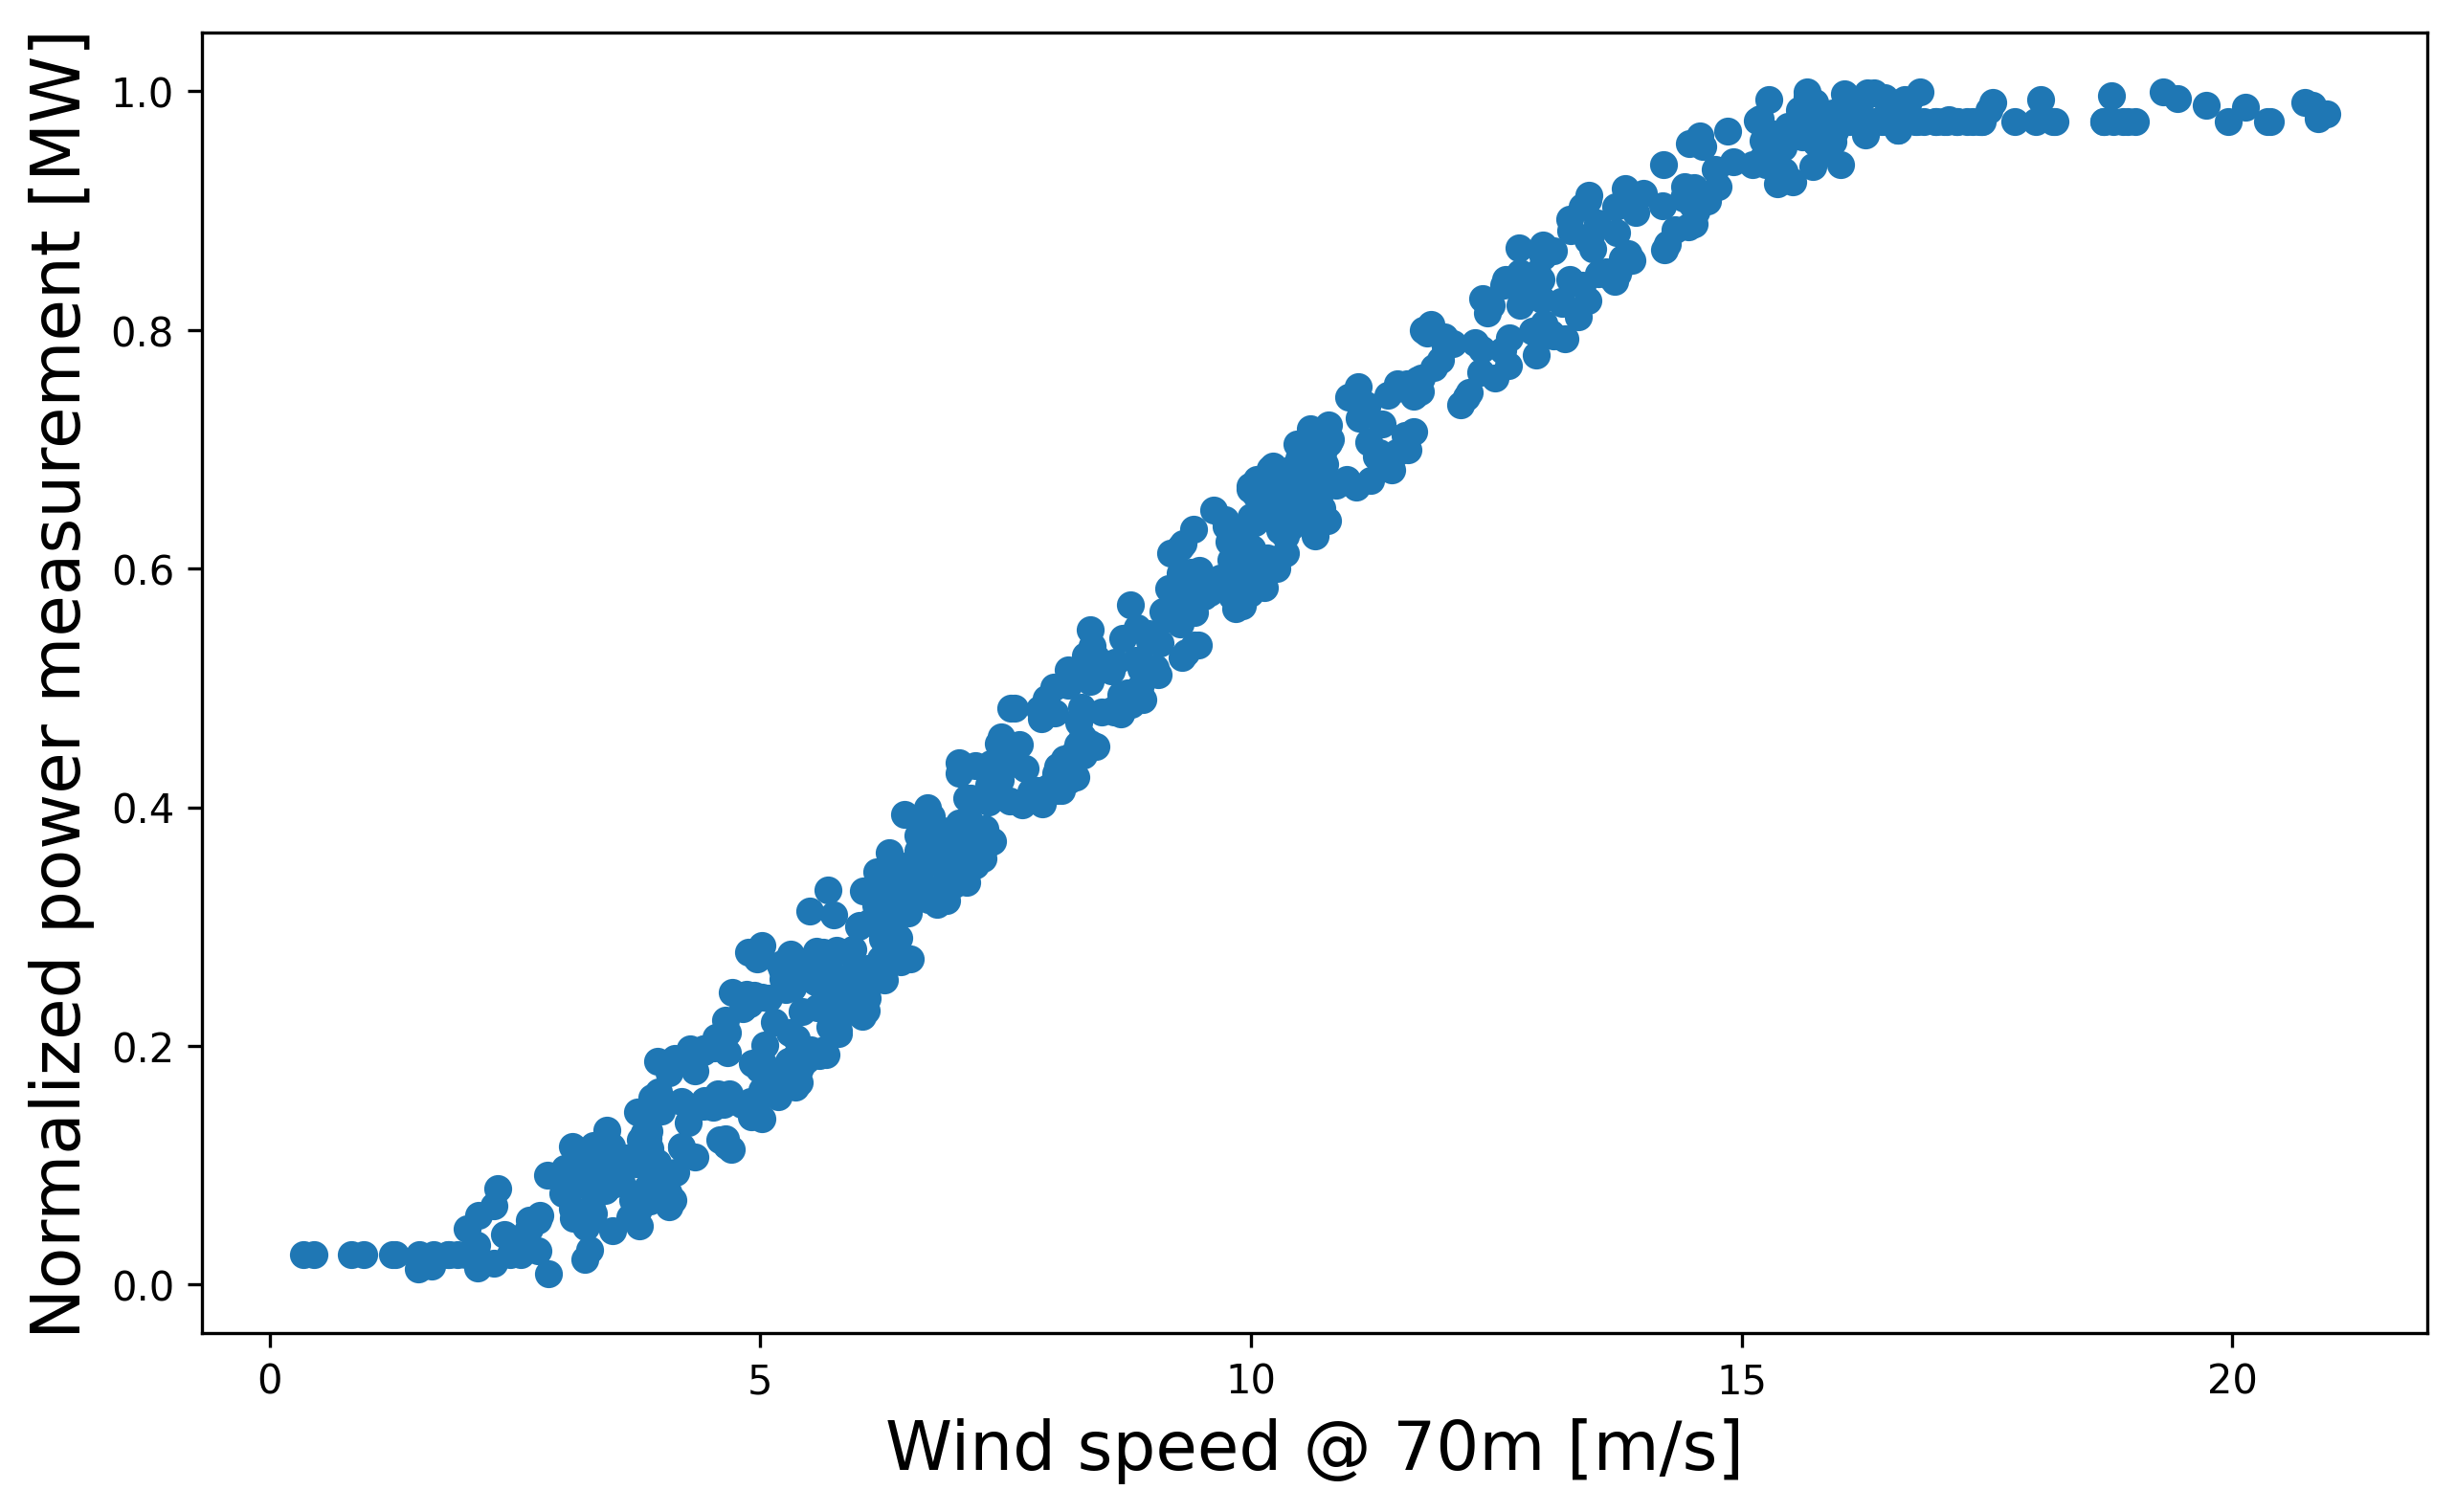

In [0]:
plt.figure(figsize=(10,6),dpi=300)
plt.scatter(weather['ws_70'], y_hat_lr)
plt.xlabel('Wind speed @ 70m [m/s]', size=17)
plt.ylabel('Normalized power measurement [MW]', size=17);
plt.savefig('lr1.png')

### Regularized Linear Regression

In [0]:
# Initialize holders
train_rlr_error = np.empty((K, 1))
test_rlr_error = np.empty((K, 1))
train_nofeatures_error = np.empty((K, 1))
test_nofeatures_error = np.empty((K, 1))
w_rlr = np.empty((M_2, K))

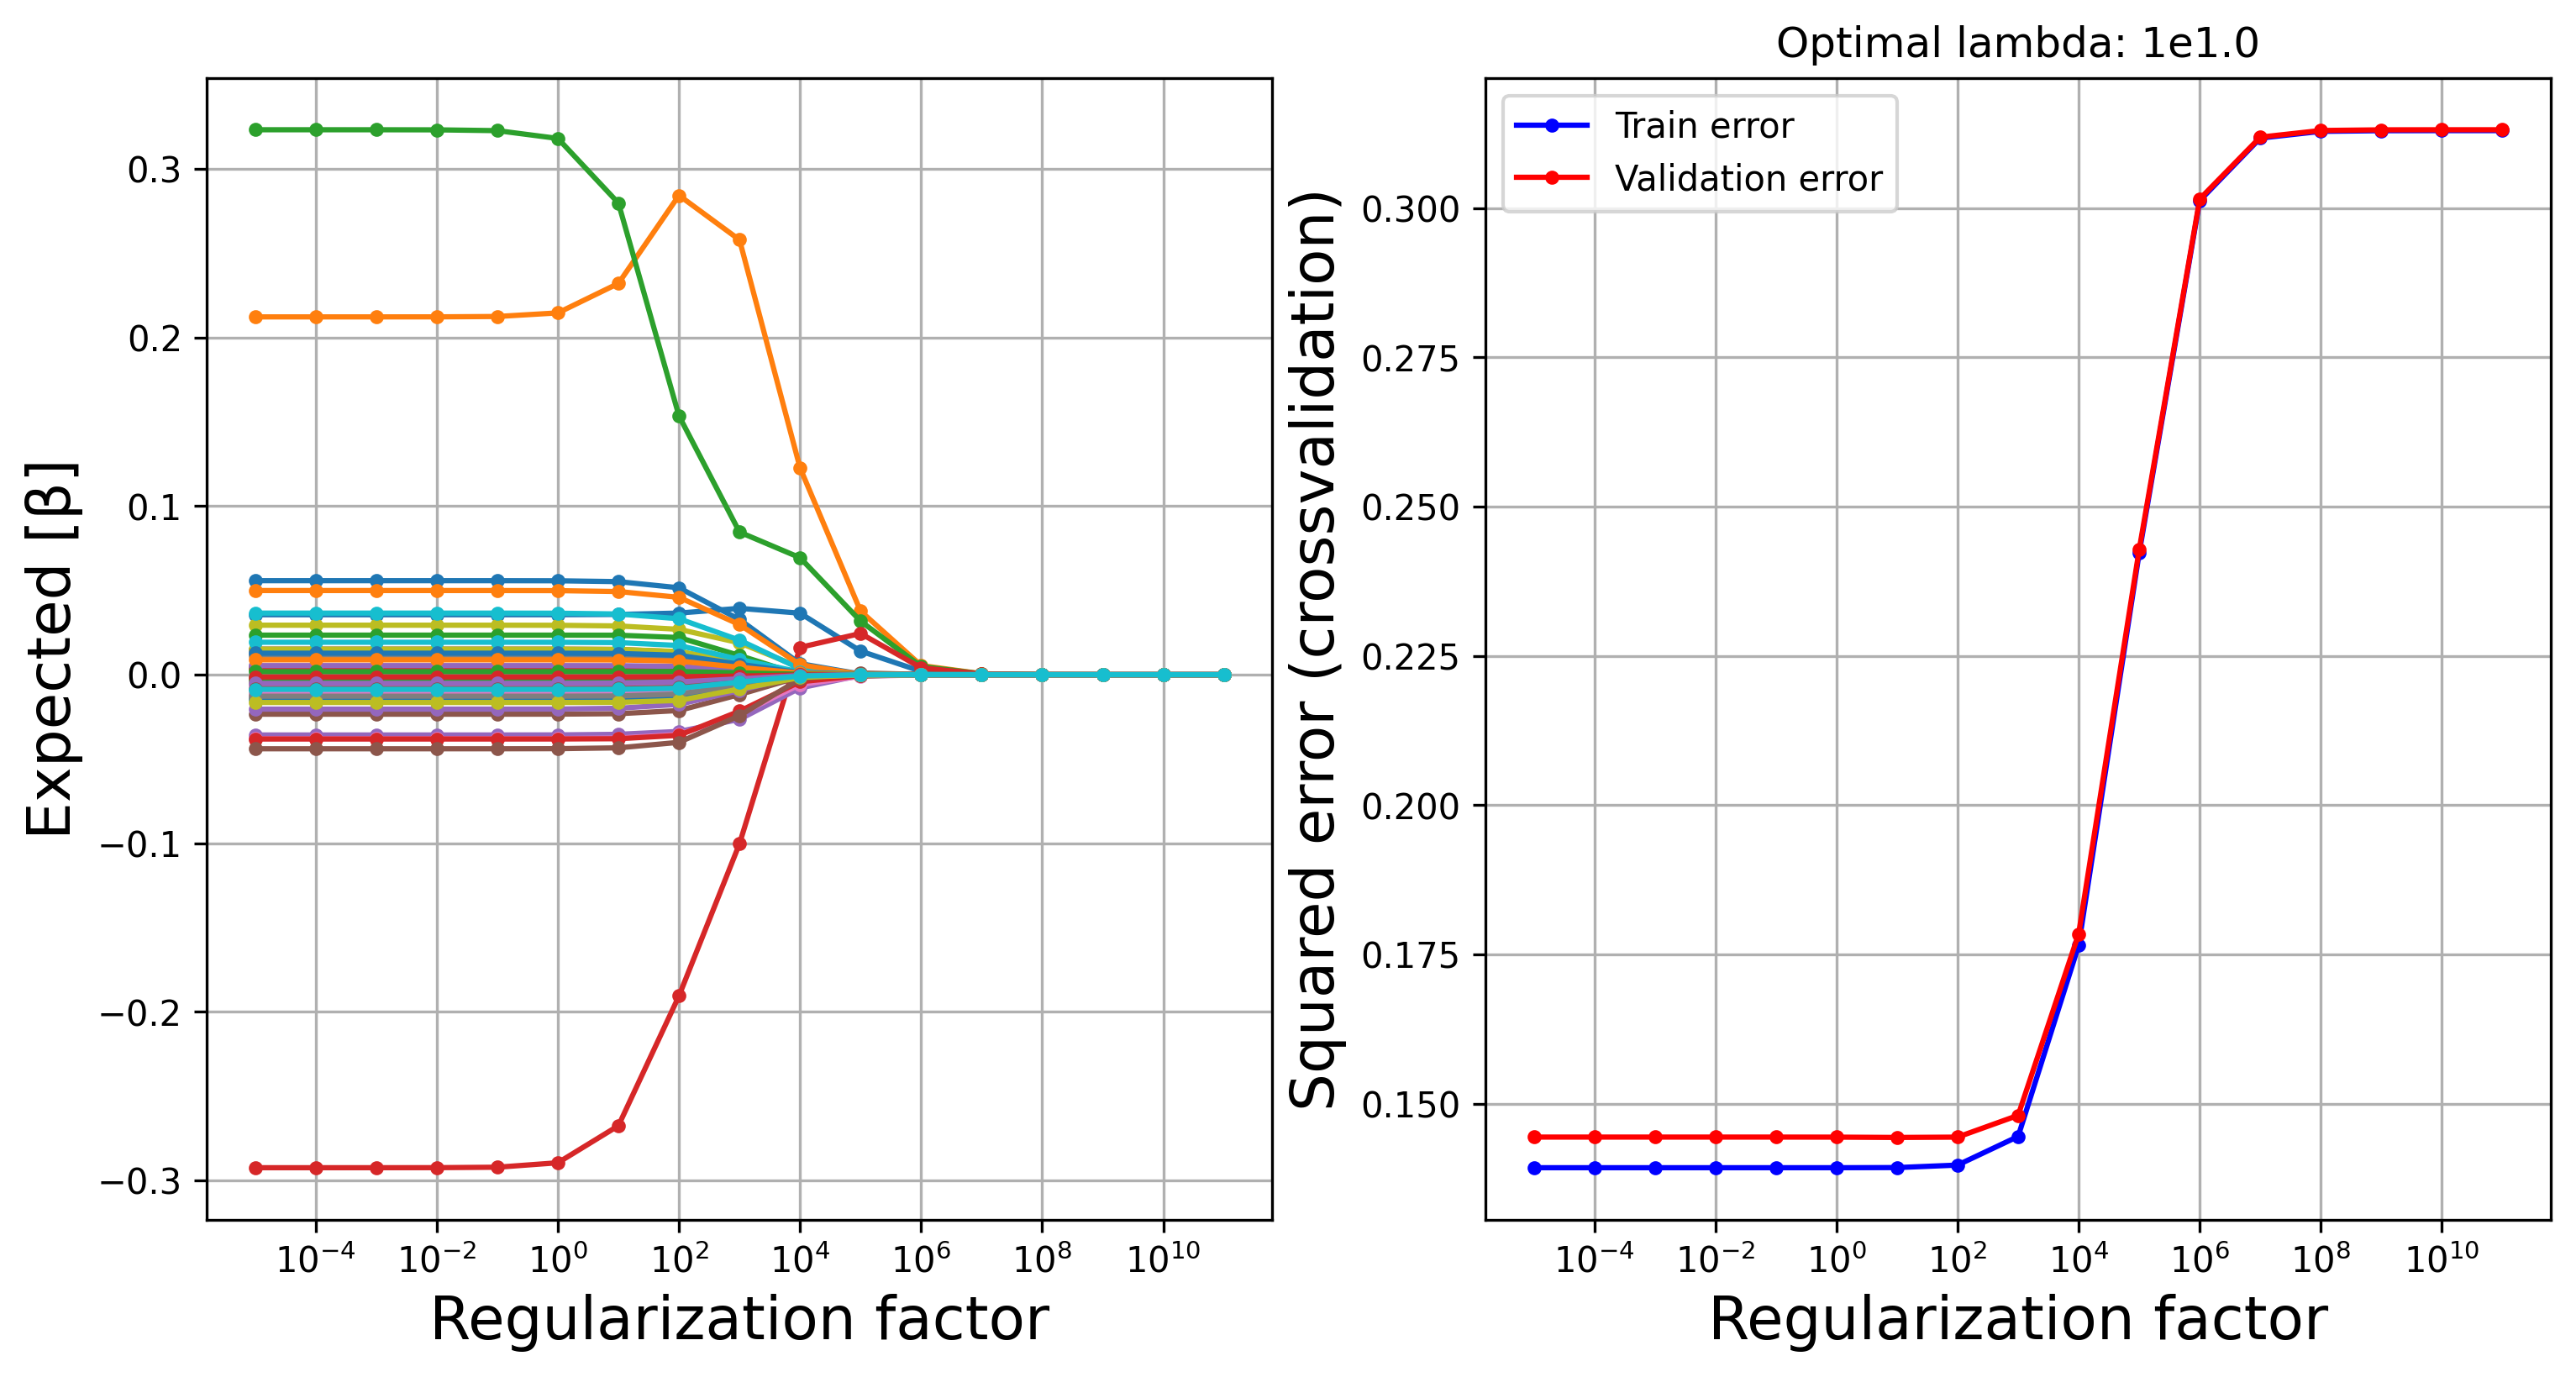

In [0]:
# Run CV of regularized linear regression 
k = 0
for train_index, test_index in cv.split(X_ones, y):
    
    # Extract training and test set for current CV fold
    X_train = X_ones[train_index]
    y_train = y[train_index]
    X_test = X_ones[test_index]
    y_test = y[test_index]
    y_train_n = y_train.shape[0]
    y_test_n = y_test.shape[0]
    internal_cv = 10

    # Compute RMSE without using the input data at all (to use for R2)
    train_nofeatures_error[k] = \
        np.sqrt(np.square(y_train - y_train.mean()).sum(axis=0) / y_train_n)
    test_nofeatures_error[k] = \
        np.sqrt(np.square(y_test - y_test.mean()).sum(axis=0) / y_test_n)
    
    # Inner CV to obtain optimal lambda
    opt_val_err, opt_lambda, mean_w_vs_lambda, train_err_vs_lambda, test_err_vs_lambda = \
        rlr_validate(X_train, y_train, lambdas, internal_cv)
   
    # Precompute matrix multiplication
    Xty = X_train.T @ y_train
    XtX = X_train.T @ X_train

    # Estimate weights for the optimal value of lambda on entire training set
    lambdaI = opt_lambda * np.eye(M_2)
    lambdaI[0, 0] = 0 # Do not regularize the bias term
    w_rlr[:,k] = np.linalg.solve(XtX + lambdaI, Xty).squeeze()

    # Compute rmse with regularization with optimal lambda
    train_rlr_error[k] = \
        np.sqrt(np.square(y_train - X_train @ w_rlr[:,k]).sum(axis=0) / y_train_n)
    test_rlr_error[k] = \
        np.sqrt(np.square(y_test - X_test @ w_rlr[:,k]).sum(axis=0) / y_test_n)

    # Display the results for the last cross-validation fold
    if k == K - 1:
        plt.figure(k, figsize=(12,6), dpi=300)
        plt.subplot(1,2,1)
        plt.semilogx(lambdas, mean_w_vs_lambda.T[:, 1:],'.-') # Don't plot the bias term
        plt.xlabel('Regularization factor', size=17)
        plt.ylabel('Expected [β]', size=17)
        plt.grid() 
        #plt.legend(attributes, loc='best')
        
        plt.subplot(1,2,2)
        plt.title('Optimal lambda: 1e{0}'.format(np.log10(opt_lambda)))
        plt.loglog(lambdas,
                   train_err_vs_lambda.T,
                   'b.-',
                   lambdas,
                   test_err_vs_lambda.T,
                   'r.-')
        plt.xlabel('Regularization factor',size=17)
        plt.ylabel('Squared error (crossvalidation)',size=17)
        plt.yscale('linear')
        plt.legend(['Train error','Validation error'])
        plt.grid()

    k += 1


plt.savefig('nice.png')

In [0]:
# Display results
print('Regularized linear regression:')
print('- Training error: {0}'.format(train_rlr_error.mean()))
print('- Test error:     {0}'.format(test_rlr_error.mean()))
print('- R^2 train:     {0}'.format(
    (train_nofeatures_error.sum() - train_rlr_error.sum()) / train_nofeatures_error.sum()))
print('- R^2 test:     {0}\n'.format(
    (test_nofeatures_error.sum() - test_rlr_error.sum()) / test_nofeatures_error.sum()))

print('Weights in last fold:')
for m in range(M_2):
    print('{:>15} {:>15}'.format(attributes[m], np.round(w_rlr[m,-1],2)))

Regularized linear regression:
- Training error: 0.1398637610832249
- Test error:     0.14007161143838998
- R^2 train:     0.5532937460181003
- R^2 test:     0.5525840946551225

Weights in last fold:
         Offset            0.52
          wd_70            0.04
          ws_70            0.23
        ws_70^2            0.28
        ws_70^3           -0.27
        month_1           -0.04
        month_2           -0.02
        month_3           -0.04
        month_4             0.0
        month_5            0.03
        month_6            0.04
        month_7            0.06
        month_8            0.05
        month_9            0.02
       month_10           -0.04
       month_11           -0.02
       month_12           -0.04
         hour_1           -0.01
         hour_2            -0.0
         hour_3            -0.0
         hour_4            -0.0
         hour_5           -0.01
         hour_6           -0.01
         hour_7            -0.0
         hour_8             0.0


In [0]:
# Use weights
weights = w_rlr.mean(axis=1)

# Estimate forecast
y_hat_rlr = weights @ X_predict_ones.T

# Truncate if over 1
estimates = [0.975 if y_hat > 1 else 0.025 if y_hat < 0 else y_hat for y_hat in y_hat_rlr]
y_hat_rlr = np.array(estimates)

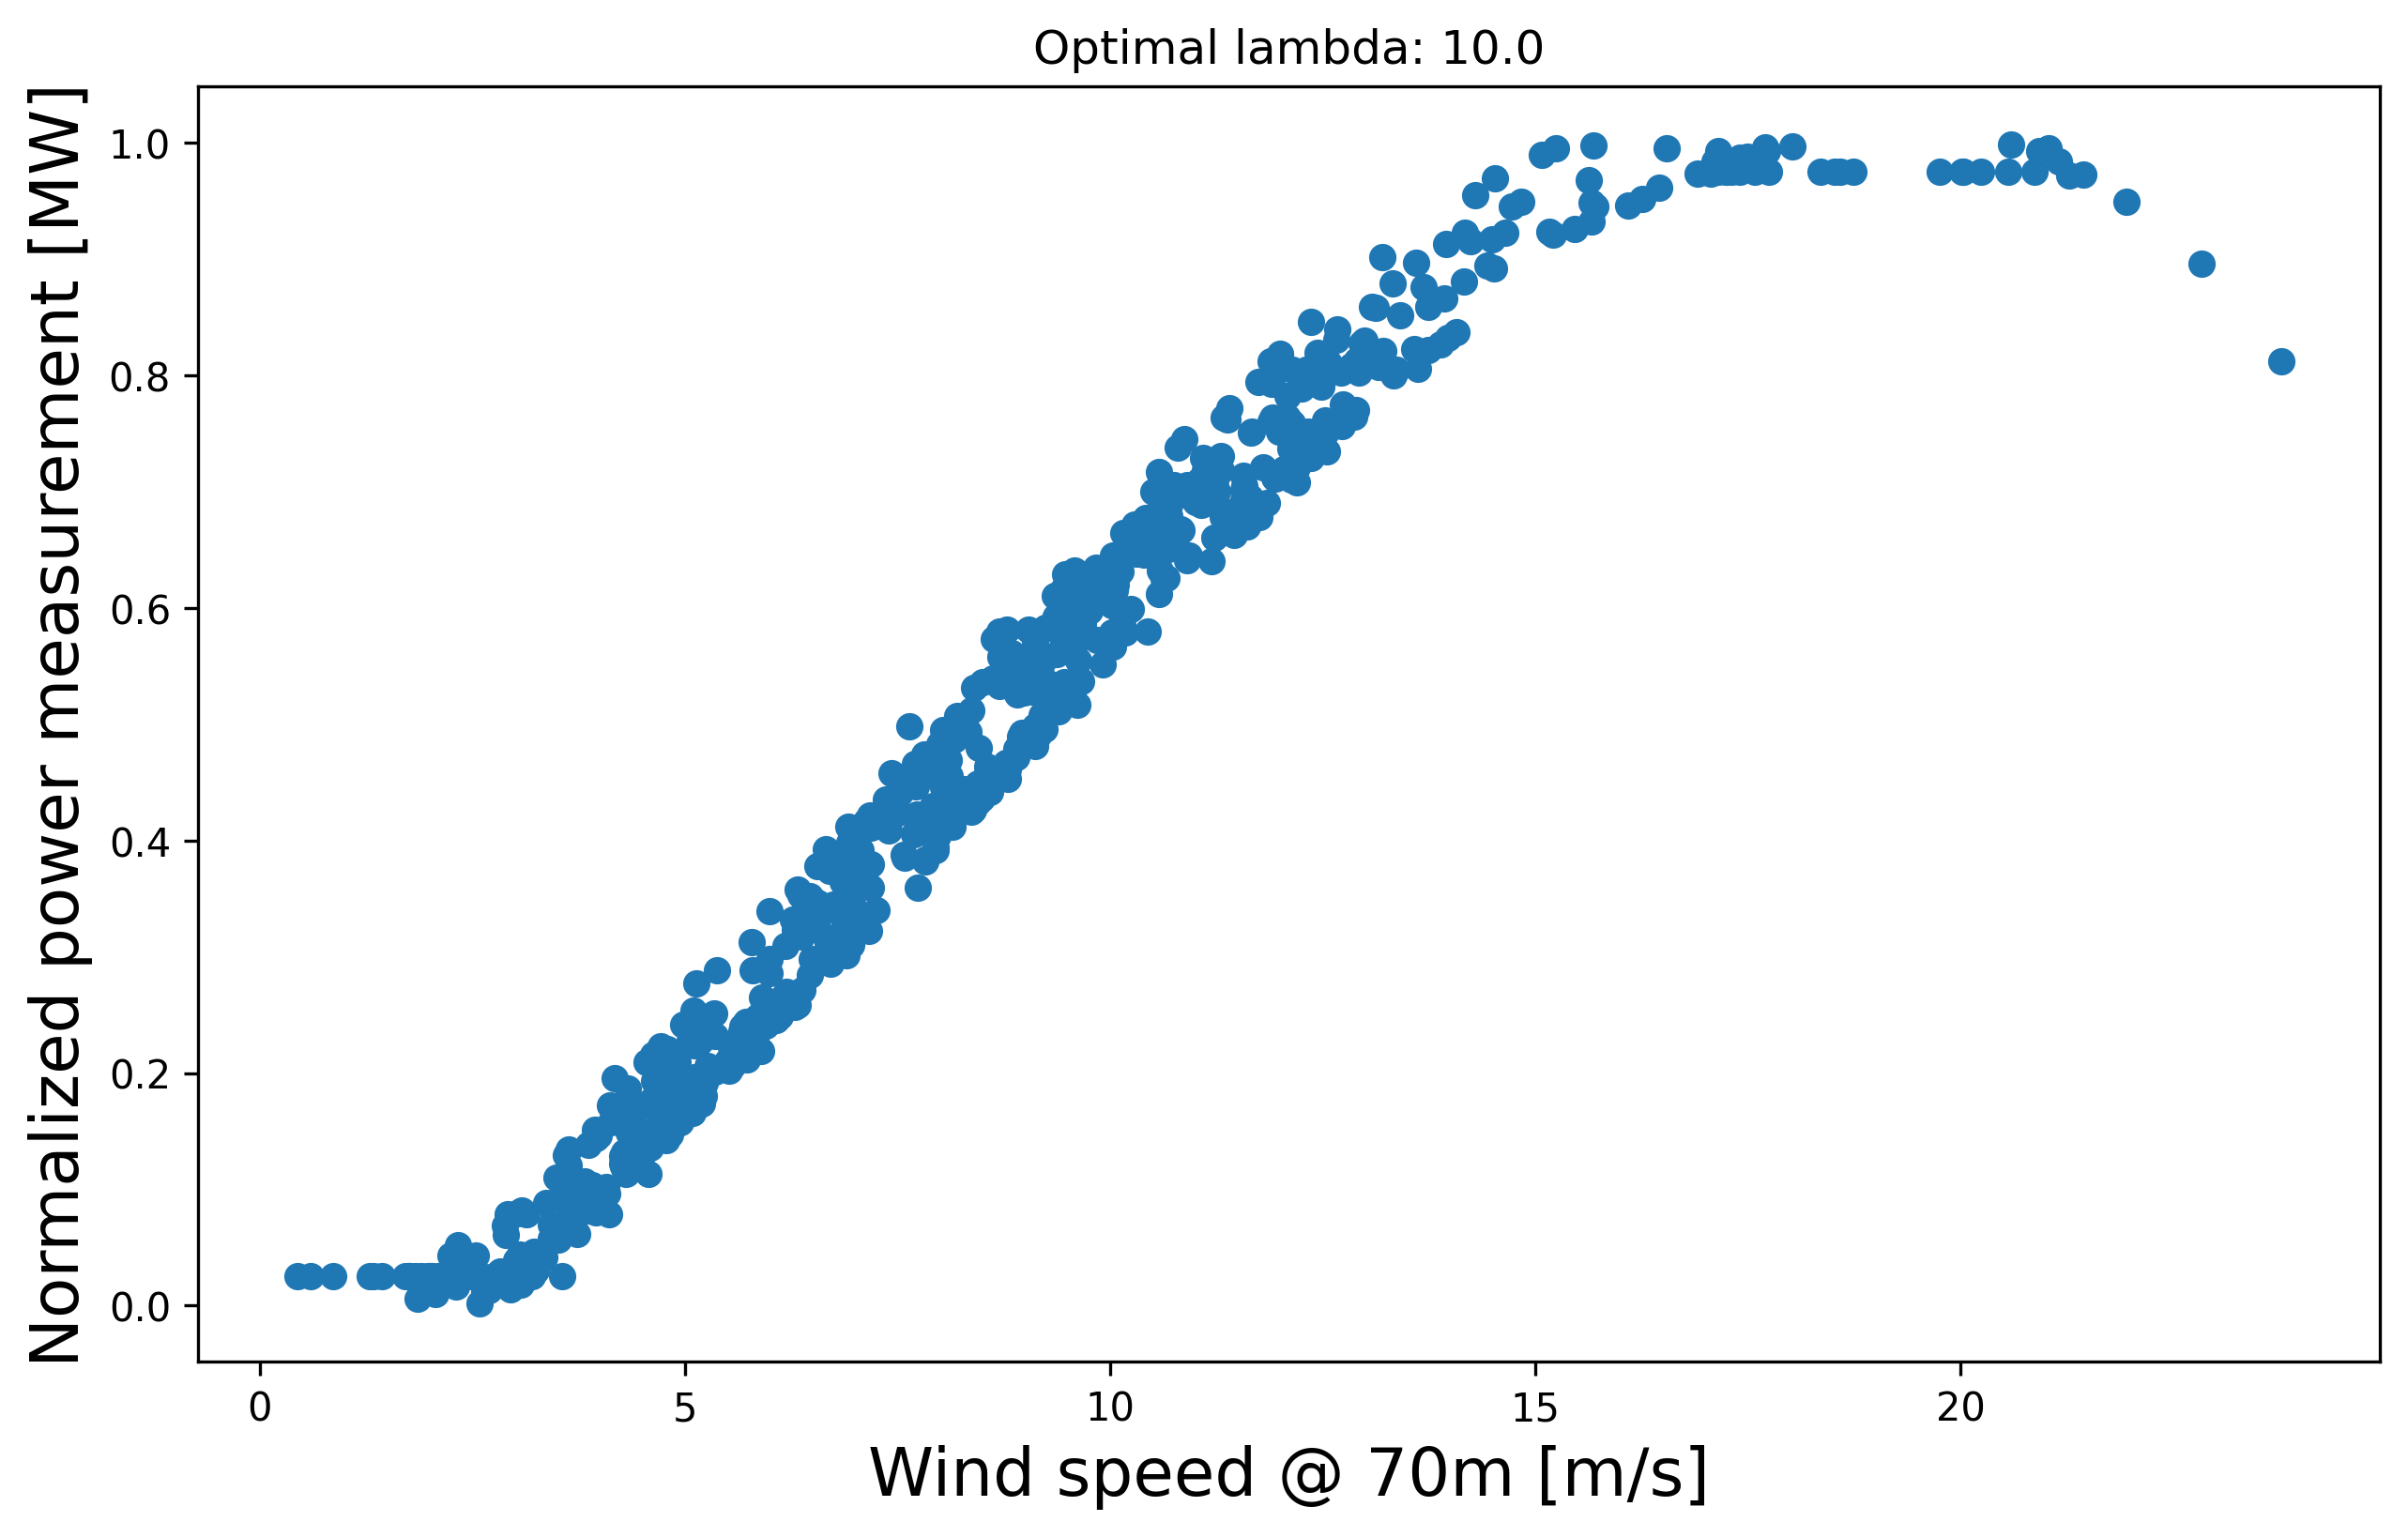

In [0]:
plt.figure(figsize=(10,6),dpi=300)
plt.scatter(weather['ws_70'], y_hat_rlr)
plt.xlabel('Wind speed @ 70m [m/s]', size=17)
plt.ylabel('Normalized power measurement [MW]', size=17)
plt.title('Optimal lambda: {0}'.format(opt_lambda));
plt.savefig('rlrstage3.png')

### Ridge Regression

In [0]:
# Define RidgeRegression model
regr = linear_model.Ridge(alpha=10, fit_intercept=True)
regr.fit(X, y)

y_hat_rr = regr.predict(X_predict) # estimates

# Adjust if over 1
y_hat_rr = np.array(
    [0.975 if y_hat > 1 else 0.025 if y_hat < 0 else y_hat for y_hat in y_hat_rr])

In [0]:
# Coefficients
rr_coef = regr.coef_
for i, coef in enumerate(rr_coef):
    print('β_%i: %.6f' %(i, coef))

β_0: 0.036000
β_1: 0.228213
β_2: 0.285636
β_3: -0.270599
β_4: -0.028970
β_5: -0.023552
β_6: -0.037049
β_7: 0.003513
β_8: 0.028016
β_9: 0.036195
β_10: 0.053638
β_11: 0.050090
β_12: 0.024025
β_13: -0.039012
β_14: -0.020904
β_15: -0.045989
β_16: -0.007808
β_17: -0.001041
β_18: -0.004831
β_19: -0.002771
β_20: -0.012452
β_21: -0.010256
β_22: -0.001932
β_23: 0.002189
β_24: 0.007950
β_25: 0.012782
β_26: 0.012294
β_27: 0.014610
β_28: 0.018438
β_29: 0.017715
β_30: 0.013077
β_31: 0.008966
β_32: 0.000479
β_33: -0.001648
β_34: -0.005817
β_35: -0.006966
β_36: -0.013370
β_37: -0.013092
β_38: -0.016146
β_39: -0.010371


Text(0, 0.5, 'Normalized power measurement [MW]')

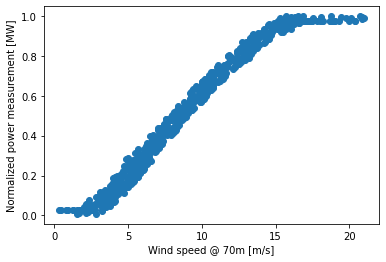

In [0]:
plt.scatter(weather['ws_70'], y_hat_rr)
plt.xlabel('Wind speed @ 70m [m/s]')
plt.ylabel('Normalized power measurement [MW]')
#plt.title('Alpha: {0}'.format(opt_lambda));

### Neural Network

In [0]:
# Parameters
hidden_units = M
#hidden_units = M - (24 + 12) + 1
loss_fn = torch.nn.MSELoss()
max_iter = 50000
n_rep_ann = 1

In [0]:
# Define holders for CV results
test_errors = []
data_test_length = []
nets = []

# Loop through CV splits
k = 0
for train_index, test_index in cv.split(X):

    print('Computing CV fold: {0}/{1}..'.format(k + 1, K))

    # Train/test split
    X_train, y_train = X[train_index,:], y[train_index]
    X_test, y_test = X[test_index,:], y[test_index]
    
    # Convert train/test matrices to tensors
    X_train_tensor = torch.tensor(X[train_index,:], dtype=torch.float)
    y_train_tensor = torch.tensor(y[train_index], dtype=torch.float)
    X_test_tensor = torch.tensor(X[test_index,:], dtype=torch.float)
    y_test_tensor = torch.tensor(y[test_index], dtype=torch.float)
    
    # Save length of train and test data
    data_train_length = float(len(y_train))
    data_test_length_tmp = float(len(y_test))
    data_test_length.append(data_test_length_tmp)
    
    # Define neural network model
    model = lambda: torch.nn.Sequential(
        torch.nn.Linear(M, M),
        torch.nn.ReLU(),
        torch.nn.Linear(M, hidden_units),
        torch.nn.ReLU(),
        torch.nn.Linear(hidden_units, hidden_units),
        torch.nn.ReLU(),
        #torch.nn.Tanh(),   
        torch.nn.Linear(hidden_units, 1),
        # no final tranfer function, i.e. "linear output"
        )
    
    # Run optimization
    net, final_loss, learning_curve = train_neural_net(model,
                                        loss_fn,
                                        X=X_train_tensor,
                                        y=y_train_tensor,
                                        n_replicates=n_rep_ann,
                                        max_iter=max_iter)
    
    # Determine estimated regression for test set
    y_est = net(X_test_tensor) # prediction of network
    
    # Determine errors and error rate
    e = (y_est.float() - y_test_tensor.float())**2
    error_rate = (sum(e).type(torch.float) / len(y_test_tensor)).data.numpy()[0]
    test_errors.append(error_rate)   

    # Save neural net
    nets.append(net)

    # Add 1 to counter
    k += 1

# Estimate the generalization error
generalization_error = np.sum(np.multiply(test_errors, data_test_length)) * (1/N)
print('est gen error of ANN: ' + str(round(generalization_error, ndigits=3)))

Computing CV fold: 1/10..

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.013585268	6.7246816e-05
		Final loss:
		1081	0.013478786	1.3819088e-07
Computing CV fold: 2/10..

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.014232924	0.00012627241
		Final loss:
		1481	0.013575568	6.17426e-07
Computing CV fold: 3/10..

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.013806137	0.00014359564
		Final loss:
		1343	0.013225537	0.0
Computing CV fold: 4/10..

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.013906279	7.1319424e-05
		Final loss:
		1411	0.013421337	0.0
Computing CV fold: 5/10..

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.014496301	0.00010252535
		2000	0.013589556	8.2368955e-05
		Final loss:
		2142	0.013469261	6.914429e-08
Computing CV fold: 6/10..

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.014295079	8.8856534e-05
		Final loss:
		1577	0.013616253	6.839787e-08
Computing CV fold: 7/10..

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.013806574	9.7260665e-05
		Final l

In [0]:
# Calculate estimate with best net
y_hat_nn = net(torch.tensor(X_predict, dtype=torch.float))
y_hat_nn = y_hat_nn.detach().numpy().flatten()
estimates = [0.975 if y_hat > 1 else 0.025 if y_hat < 0 else y_hat for y_hat in y_hat_nn]
y_hat_nn = np.array(estimates)

In [0]:
# see_weights = [nets[0].weight for i in range(0,4,2)]
# see_weights

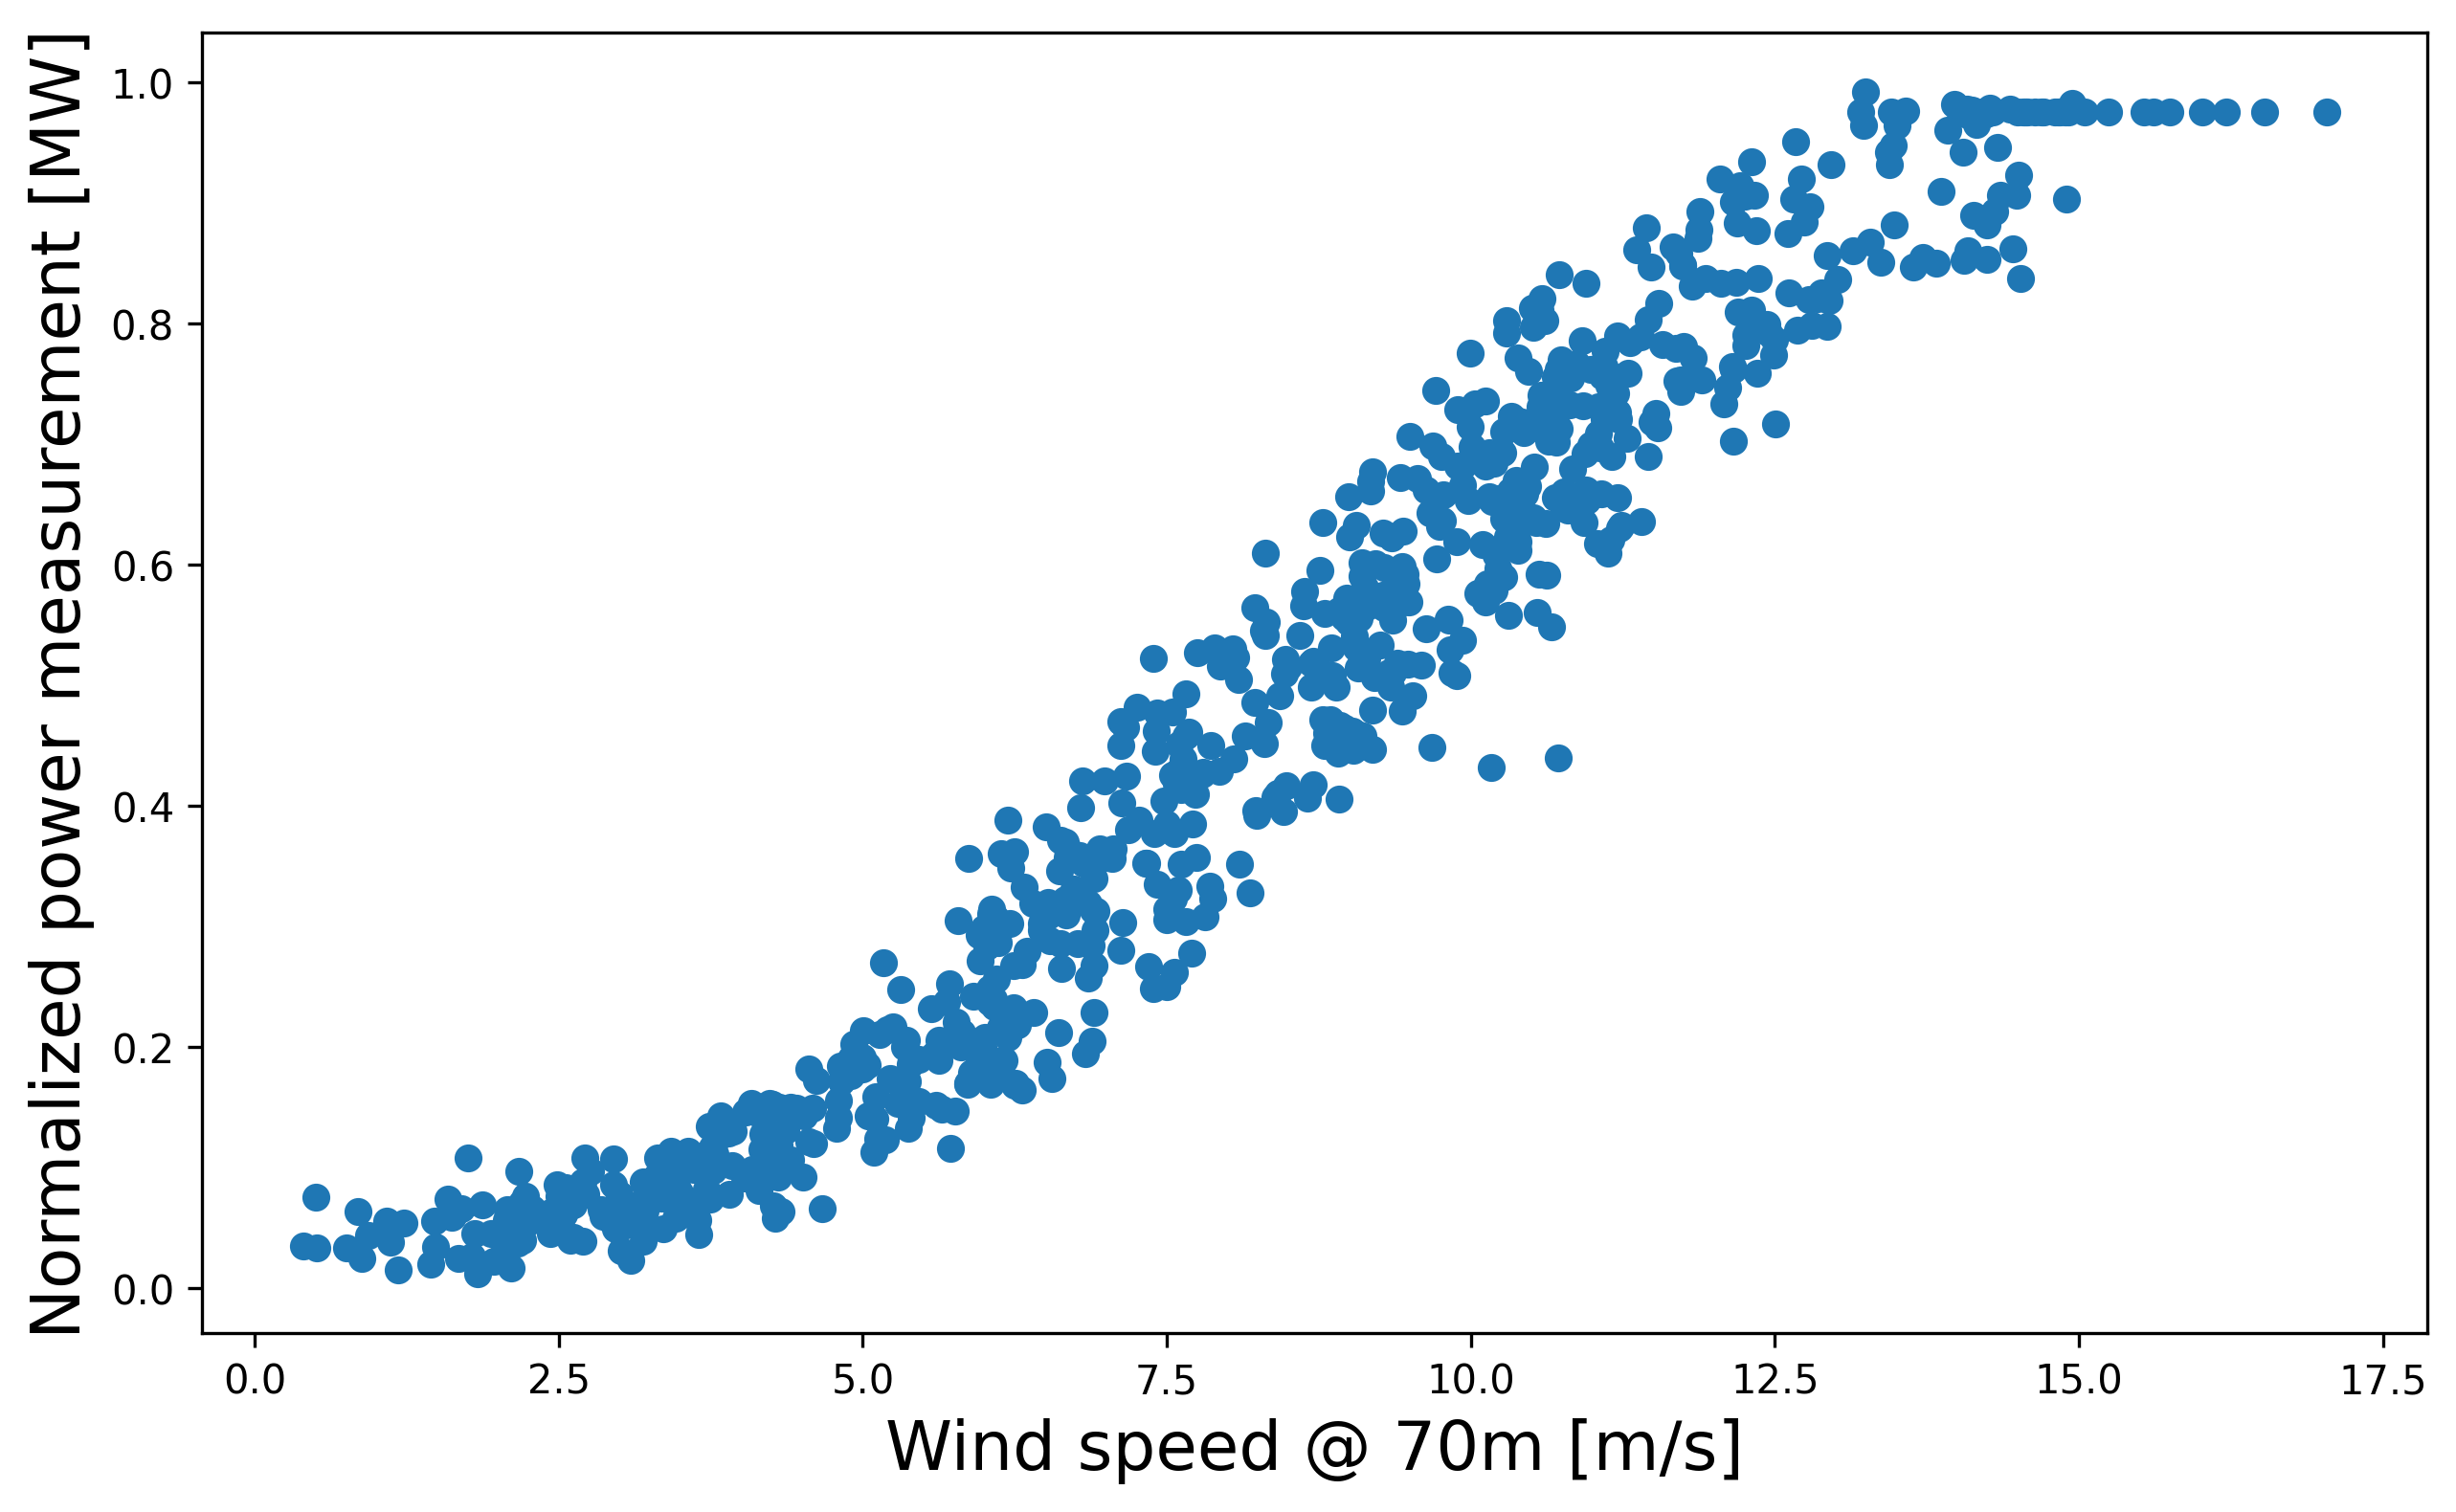

In [0]:
plt.figure(figsize=(10,6),dpi=300)
plt.scatter(weather['ws_70'], y_hat_nn)
plt.xlabel('Wind speed @ 70m [m/s]', size=17)
plt.ylabel('Normalized power measurement [MW]', size=17);
plt.savefig('nnstage4.png')

### Bayesian Linear Regression

$y_n \sim \mathcal{N}(\alpha + \beta^T \textbf{x}_n , \sigma^2)$

In [0]:
# Standardize y (to normal)
y_mean = y.mean()
y_std = y.std()
y_blr = (y - y_mean) / y_std

# Parameters
n_samples = 1000
n_steps = 10000
adam_params = {"lr": 0.001} # learning rate (lr) of optimizer
optimizer = ClippedAdam(adam_params)

# Empty arrays
alphas_blr = np.empty((n_samples, K))
betas_blr = np.empty((n_samples, M, K))
test_error_blr = np.empty((K, 1))

In [0]:
# Run CV of regularized linear regression 
k = 0
for train_index, test_index in cv.split(X, y_blr):
    
    print('Computing CV fold: {0}/{1}..'.format(k + 1, K))

    # Extract training and test set for current CV fold
    X_train = X[train_index]
    y_train = y_blr[train_index]
    X_test = X[test_index]
    y_test = y_blr[test_index]
    n_train = y_train.shape[0]
    n_test = y_test.shape[0]

    # Convert matrix to tensors
    X_train_torch = torch.tensor(X_train).float()
    y_train_torch = torch.tensor(y_train).float()
    X_test_torch = torch.tensor(X_test).float()
    y_test_torch = torch.tensor(y_test).float()

    # Define guide function
    guide = AutoMultivariateNormal(model_bayesianlr)

    # Reset parameter values
    pyro.clear_param_store()

    # Setup the inference algorithm
    elbo = Trace_ELBO(num_particles=1)
    svi = SVI(model_bayesianlr, guide, optimizer, loss=elbo)

    # Do gradient steps
    for step in range(n_steps):
        elbo = svi.step(X_train_torch, y_train_torch)
        if step % 1000 == 0:
            print("[%d] ELBO: %.1f" % (step, elbo))

    # Get samples from the model
    predictive = Predictive(model_bayesianlr, guide=guide, num_samples=n_samples,
                            return_sites=("alpha", "beta", "sigma"))
    samples = predictive(X_test_torch)
    alpha_samples = samples["alpha"].detach().numpy()
    beta_samples = samples["beta"].detach().numpy()

    # Save samples per split
    alphas_blr[:,k] = alpha_samples.squeeze()
    betas_blr[:,:,k] = beta_samples.squeeze()

    # Compute estimates from samples
    y_hat = np.mean(alpha_samples.T + np.dot(X_test_torch.numpy(), beta_samples.T),
                        axis=1)

    # Compute error
    test_error_blr[k] = \
        np.sqrt(np.square(y_test - y_hat).sum(axis=0) / y_test_n)
    
    k += 1

Computing CV fold: 1/10..
[0] ELBO: 39156.7


/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


[1000] ELBO: 20214.6
[2000] ELBO: 15151.0
[3000] ELBO: 15153.0
[4000] ELBO: 15039.9
[5000] ELBO: 15033.9
[6000] ELBO: 14906.6
[7000] ELBO: 15072.4
[8000] ELBO: 14937.6
[9000] ELBO: 14997.4
Computing CV fold: 2/10..
[0] ELBO: 42580.1
[1000] ELBO: 18758.9
[2000] ELBO: 15620.4
[3000] ELBO: 15190.0
[4000] ELBO: 14931.3
[5000] ELBO: 15017.9
[6000] ELBO: 14940.8
[7000] ELBO: 14954.0
[8000] ELBO: 15020.1
[9000] ELBO: 14923.4
Computing CV fold: 3/10..
[0] ELBO: 52688.4
[1000] ELBO: 19371.8
[2000] ELBO: 16051.4
[3000] ELBO: 15140.9
[4000] ELBO: 15215.4
[5000] ELBO: 15112.3
[6000] ELBO: 14984.9
[7000] ELBO: 14991.3
[8000] ELBO: 14949.3
[9000] ELBO: 14987.2
Computing CV fold: 4/10..
[0] ELBO: 30978.6
[1000] ELBO: 18535.1
[2000] ELBO: 15603.9
[3000] ELBO: 15147.2
[4000] ELBO: 15120.7
[5000] ELBO: 15216.1
[6000] ELBO: 15060.9
[7000] ELBO: 14940.6
[8000] ELBO: 15006.0
[9000] ELBO: 14922.0
Computing CV fold: 5/10..
[0] ELBO: 30380.2
[1000] ELBO: 16297.3
[2000] ELBO: 15150.9
[3000] ELBO: 14947.6
[4000

In [0]:
# Set actual test sets
X_test_torch = torch.tensor(X_predict).float()
y_test_torch = torch.tensor(y_sol).float()

# Get samples from the model
predictive = Predictive(model_bayesianlr, guide=guide, num_samples=1000,
                        return_sites=("alpha", "beta", "sigma"))
samples = predictive(X_test_torch)
alpha_samples = samples["alpha"].detach().numpy()
beta_samples = samples["beta"].detach().numpy()

# Compute from samples and re-normalize
y_hat_blr = np.mean(alpha_samples.T + np.dot(X_test_torch.numpy(), beta_samples.T), axis=1)
y_hat_blr = y_hat_blr * y_std + y_mean

# Adjust if over 1 or below zero
y_hat_blr = np.array(
    [0.975 if y_hat > 1 else 0.025 if y_hat < 0 else y_hat for y_hat in y_hat_blr])

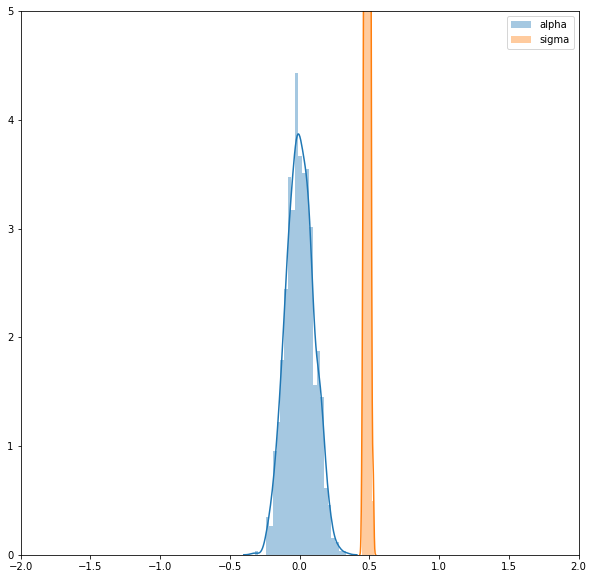

In [0]:
# Intercept and error
plt.figure(figsize=(10,10))
sns.distplot(alpha_samples)
sns.distplot(samples["sigma"].detach().numpy())
plt.legend(["alpha", "sigma"])
plt.axis([-2,2,0,5]);

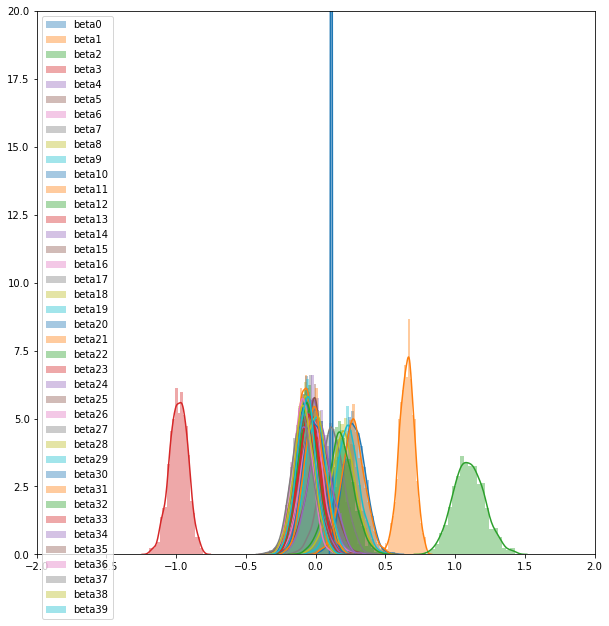

In [0]:
# Beta parameters
plt.figure(figsize=(10,10))
for i in range(M):
    sns.distplot(beta_samples[:, i])
plt.legend(["beta%d" % i for i in range(M)])
plt.axis([-2,2,0,20])
plt.show()

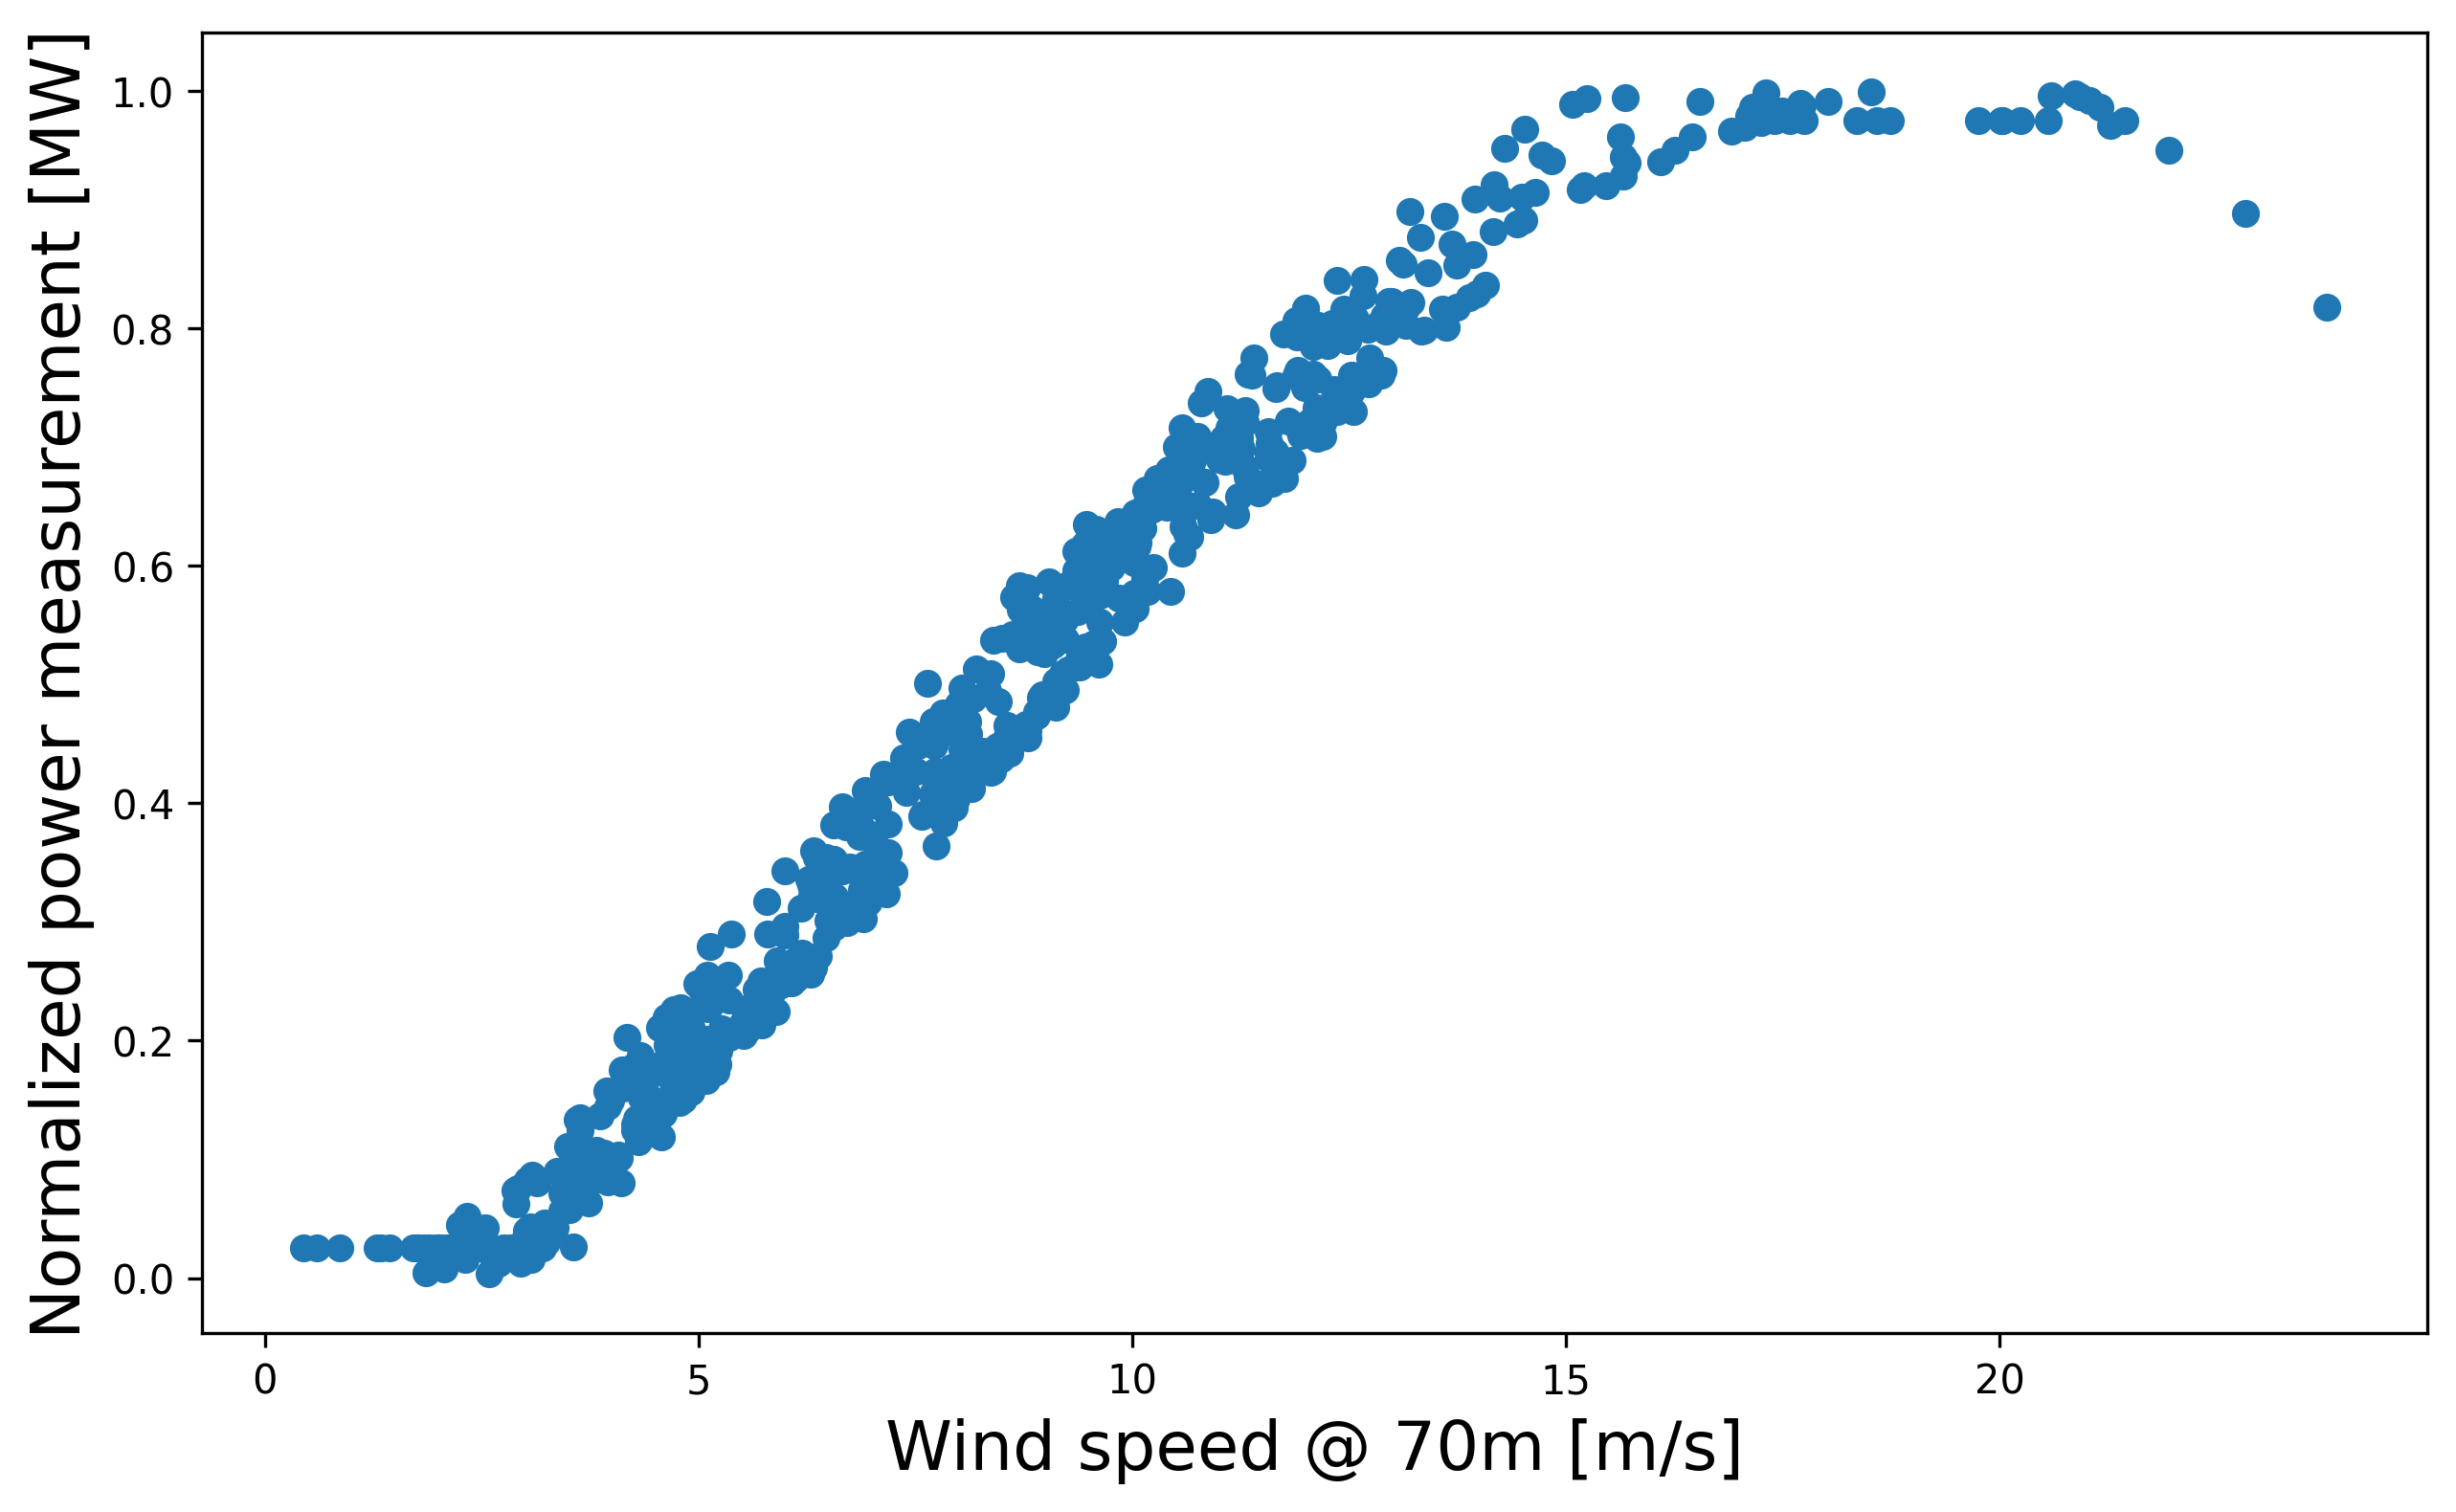

In [0]:
plt.figure(figsize=(10,6),dpi=300)
plt.scatter(weather['ws_70'], y_hat_blr)
plt.xlabel('Wind speed @ 70m [m/s]',size=17)
plt.ylabel('Normalized power measurement [MW]',size=17);
plt.savefig('blrstage3.png')

### Bayesian Neural Network

In [0]:
# Set general options
print_cv_loop_text = True

# ANN options
loss_fn = torch.nn.MSELoss()
max_iter = 50000
n_rep_ann = 1

# Set K-folded CV options 
K = 10 # Number of loops
cv  = model_selection.KFold(n_splits=K, shuffle=False)

In [0]:
# Initialize error matrix
error_matrix = []

# Outer loop
k_outer = 0
for train_index, test_index in cv.split(X):

    if(print_cv_loop_text):
        print('Computing cv fold: {0}/{1}..'.format(k_outer + 1, K_1))

    # Train/test split
    X_train_torch, y_train_torch = X[train_outer_index,:], y[train_outer_index]
    X_test_torch, y_test_torch = X[test_outer_index,:], y[test_outer_index]

    # Convert train/test matrices to tensors
    X_train_tensor = torch.tensor(X[train_index,:]).float()
    y_train_tensor = torch.tensor(y[train_index]).float()
    X_test_tensor = torch.tensor(X[test_index,:]).float()
    y_test_tensor = torch.tensor(y[test_index]).float()

    # Define guide function
    guide = AutoDiagonalNormal(model_bnnet)

    # Reset parameter values
    pyro.clear_param_store()

    # Define the number of optimization steps
    n_steps = 10000

    # Setup the optimizer
    adam_params = {"lr": 0.01}
    optimizer = Adam(adam_params)

    # Setup the inference algorithm
    elbo = Trace_ELBO(num_particles=1)
    svi = SVI(model_bnnet, guide, optimizer, loss=elbo)

    # Do gradient steps
    for step in range(n_steps):
        elbo = svi.step(X_train_tensor, y_train_tensor)
        if step % 2500 == 0:
            print("[%d] ELBO: %.1f" % (step, elbo))

    # Make predictions for test set
    predictive = Predictive(model_bnnet, guide=guide, num_samples=1000,
                            return_sites=("obs", "_RETURN"))
    samples = predictive(X_test_tensor)
    y_hat_bnnet = samples["obs"].mean(axis=0).detach().numpy()

    error_matrix.append(compute_error(y_test, y_hat_bnnet))

    k_outer += 1

In [0]:
# Prepare data for Pyro by converting it into PyTorch tensors
X_train_torch = torch.tensor(X_train).float()
y_train_torch = torch.tensor(y_train).float()

# Define guide function
guide = AutoDiagonalNormal(model_bnnet)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 10000

# Setup the optimizer
adam_params = {"lr": 0.01}
optimizer = Adam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(model_bnnet, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train_torch, y_train_torch)
    if step % 500 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

/usr/local/lib/python3.6/dist-packages/pyro/primitives.py:406: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  "modules from `torch.nn.Module` instances.", FutureWarning)


[0] ELBO: 70516508.8
[500] ELBO: 12453565.6
[1000] ELBO: 13539637.6
[1500] ELBO: 4298118.9
[2000] ELBO: 3627975.8
[2500] ELBO: 3476865.6
[3000] ELBO: 3404030.3
[3500] ELBO: 3395118.9
[4000] ELBO: 3221090.0
[4500] ELBO: 3104371.1
[5000] ELBO: 3010334.0
[5500] ELBO: 2867925.6
[6000] ELBO: 2821884.9
[6500] ELBO: 2618764.1
[7000] ELBO: 2385297.7
[7500] ELBO: 2337269.6
[8000] ELBO: 2384676.9
[8500] ELBO: 2180728.8
[9000] ELBO: 2148715.6
[9500] ELBO: 2147375.9


In [0]:
# Prepare test data for Pyro
X_sol_torch = torch.tensor(X_predict).float()

# Make predictions for test set
predictive = Predictive(model_bnnet, guide=guide, num_samples=1000,
                        return_sites=("obs", "_RETURN"))
samples = predictive(X_sol_torch)
y_hat_bnnet = samples["obs"].mean(axis=0).detach().numpy()

### Catboost

In [0]:
# Use dataframes and get indices of categorical features (month, hour)
X = train.drop('POWER', axis=1)
y = train.POWER

# Normalize
X.wd_70 = (X.wd_70 - X.wd_70.mean())/X.wd_70.std() # normalize
X.ws_70 = (X.ws_70 - X.ws_70.mean())/X.ws_70.std() # normalize
weather.wd_70 = (weather.wd_70 - weather.wd_70.mean())/weather.wd_70.std()
weather.ws_70 = (weather.ws_70 - weather.ws_70.mean())/weather.ws_70.std()

# Categorical features indices
categorical_features_indices = np.where(X.dtypes != np.float)[0]

In [0]:
# Optimize hyperparameters (L2 leaf and learning rate)
def hyperopt_objective(params):
    model = CatBoostRegressor(
        l2_leaf_reg=int(params['l2_leaf_reg']),
        learning_rate=params['learning_rate'],
        iterations=100,
        random_seed=42, # to keep 
        verbose=False, # avoid printing
        loss_function='RMSE',
        task_type='GPU' # comment out if on CPU
    )
    
    cv_data = cv(
        Pool(X, y, cat_features=categorical_features_indices),
        model.get_params()  # K-3 cross-validation (default)
    )
    best_RMSE = np.min(cv_data['test-RMSE-mean']) # RMSE mean (on test)
    
    return best_RMSE # minimizes RMSE

In [0]:
from catboost import CatBoostRegressor, Pool, cv

In [0]:
from numpy.random import RandomState

# Randomize parameter space (L2 and learning rate)
params_space = {
    'l2_leaf_reg': hyperopt.hp.qloguniform('l2_leaf_reg', 0, 2, 1), # default is 3
    'learning_rate': hyperopt.hp.uniform('learning_rate', 1e-3, 5e-1), # default is 3e-2
}

trials = hyperopt.Trials()

# Get best parameters
best = hyperopt.fmin(
    hyperopt_objective, # obj funct
    space=params_space, # param space
    algo=hyperopt.tpe.suggest, # tree of Parzen, suggest
    max_evals=100,
    trials=trials,
    rstate=RandomState(123)
)

100%|██████████| 100/100 [10:42<00:00,  6.42s/it, best loss: 0.12447766507729585]


In [0]:
print(best)

{'l2_leaf_reg': 2.0, 'learning_rate': 0.3081370355179906}


In [0]:
# Train model with optimized L2 and learning rate
model = CatBoostRegressor(
    l2_leaf_reg=int(best['l2_leaf_reg']), # remove, best lambda is 3 (default)
    learning_rate=best['learning_rate'], # 0.3-0.4, instead of 0.03, gradient step
    iterations=1000,
    random_seed=42,
    verbose=True,
    loss_function='RMSE',
    task_type='GPU'
)
cv_data = cv(Pool(X, y, cat_features=categorical_features_indices), model.get_params(),
             fold_count=10) #K-10 cross-validation

0:	learn: 0.4349919	test: 0.4349635	best: 0.4349635 (0)
1:	learn: 0.3180831	test: 0.3182013	best: 0.3182013 (1)
2:	learn: 0.2435146	test: 0.2436684	best: 0.2436684 (2)
3:	learn: 0.1952818	test: 0.1955400	best: 0.1955400 (3)
4:	learn: 0.1675013	test: 0.1678452	best: 0.1678452 (4)
5:	learn: 0.1503452	test: 0.1507869	best: 0.1507869 (5)
6:	learn: 0.1407783	test: 0.1412376	best: 0.1412376 (6)
7:	learn: 0.1353955	test: 0.1358355	best: 0.1358355 (7)
8:	learn: 0.1323250	test: 0.1327868	best: 0.1327868 (8)
9:	learn: 0.1304835	test: 0.1310255	best: 0.1310255 (9)
10:	learn: 0.1292619	test: 0.1298669	best: 0.1298669 (10)
11:	learn: 0.1282636	test: 0.1289266	best: 0.1289266 (11)
12:	learn: 0.1277552	test: 0.1284410	best: 0.1284410 (12)
13:	learn: 0.1271057	test: 0.1279163	best: 0.1279163 (13)
14:	learn: 0.1267750	test: 0.1276742	best: 0.1276742 (14)
15:	learn: 0.1264633	test: 0.1273880	best: 0.1273880 (15)
16:	learn: 0.1261625	test: 0.1270617	best: 0.1270617 (16)
17:	learn: 0.1258455	test: 0.12673

In [0]:
print('RMSE score: {}'.format(np.min(cv_data['test-RMSE-mean'])))

RMSE score: 0.12150359043142867


In [0]:
# Fit with all training data
model.fit(X, y, cat_features=categorical_features_indices)

# Get estimates
y_hat_cat = model.predict(weather)
# Truncate if over 1 or below 0
estimates = [0.9875 if y_hat > 1 else 0.0125 if y_hat < 0 else y_hat for y_hat in y_hat_cat]
y_hat_cat = np.array(estimates)

0:	learn: 0.2418120	total: 30.8ms	remaining: 30.8s
1:	learn: 0.1956969	total: 60.4ms	remaining: 30.1s
2:	learn: 0.1677614	total: 89.8ms	remaining: 29.9s
3:	learn: 0.1507737	total: 119ms	remaining: 29.7s
4:	learn: 0.1421820	total: 169ms	remaining: 33.6s
5:	learn: 0.1365340	total: 209ms	remaining: 34.6s
6:	learn: 0.1331229	total: 242ms	remaining: 34.3s
7:	learn: 0.1307759	total: 276ms	remaining: 34.2s
8:	learn: 0.1294476	total: 305ms	remaining: 33.5s
9:	learn: 0.1285836	total: 332ms	remaining: 32.9s
10:	learn: 0.1278259	total: 362ms	remaining: 32.5s
11:	learn: 0.1274941	total: 391ms	remaining: 32.2s
12:	learn: 0.1271917	total: 426ms	remaining: 32.3s
13:	learn: 0.1266974	total: 458ms	remaining: 32.2s
14:	learn: 0.1262739	total: 484ms	remaining: 31.8s
15:	learn: 0.1258171	total: 513ms	remaining: 31.5s
16:	learn: 0.1253165	total: 543ms	remaining: 31.4s
17:	learn: 0.1251677	total: 571ms	remaining: 31.2s
18:	learn: 0.1250699	total: 598ms	remaining: 30.9s
19:	learn: 0.1246633	total: 625ms	rema

# Results

In [0]:
# Merge results stage 1
results = [y_hat_lr, y_hat_rr]
labs = ['Linear Regression','Ridge Regression']
residuals = [y_sol - r for r in results]

In [0]:
# Merge results stage 2
results = [y_hat_lr, y_hat_rlr, y_hat_rr, y_hat_nn]
labs = ['Linear Regression','Regularized LR', 'Ridge Regression',
              'Neural Network']
residuals = [y_sol - r for r in results]

In [0]:
# Merge results stage 3
results = [y_hat_rlr, y_hat_blr, y_hat_nn, y_hat_cat]
labs = ['Regularized Linear Regression','Bayesian LR', 'Neural Network',
              'Catboost']
residuals = [y_sol - r for r in results]

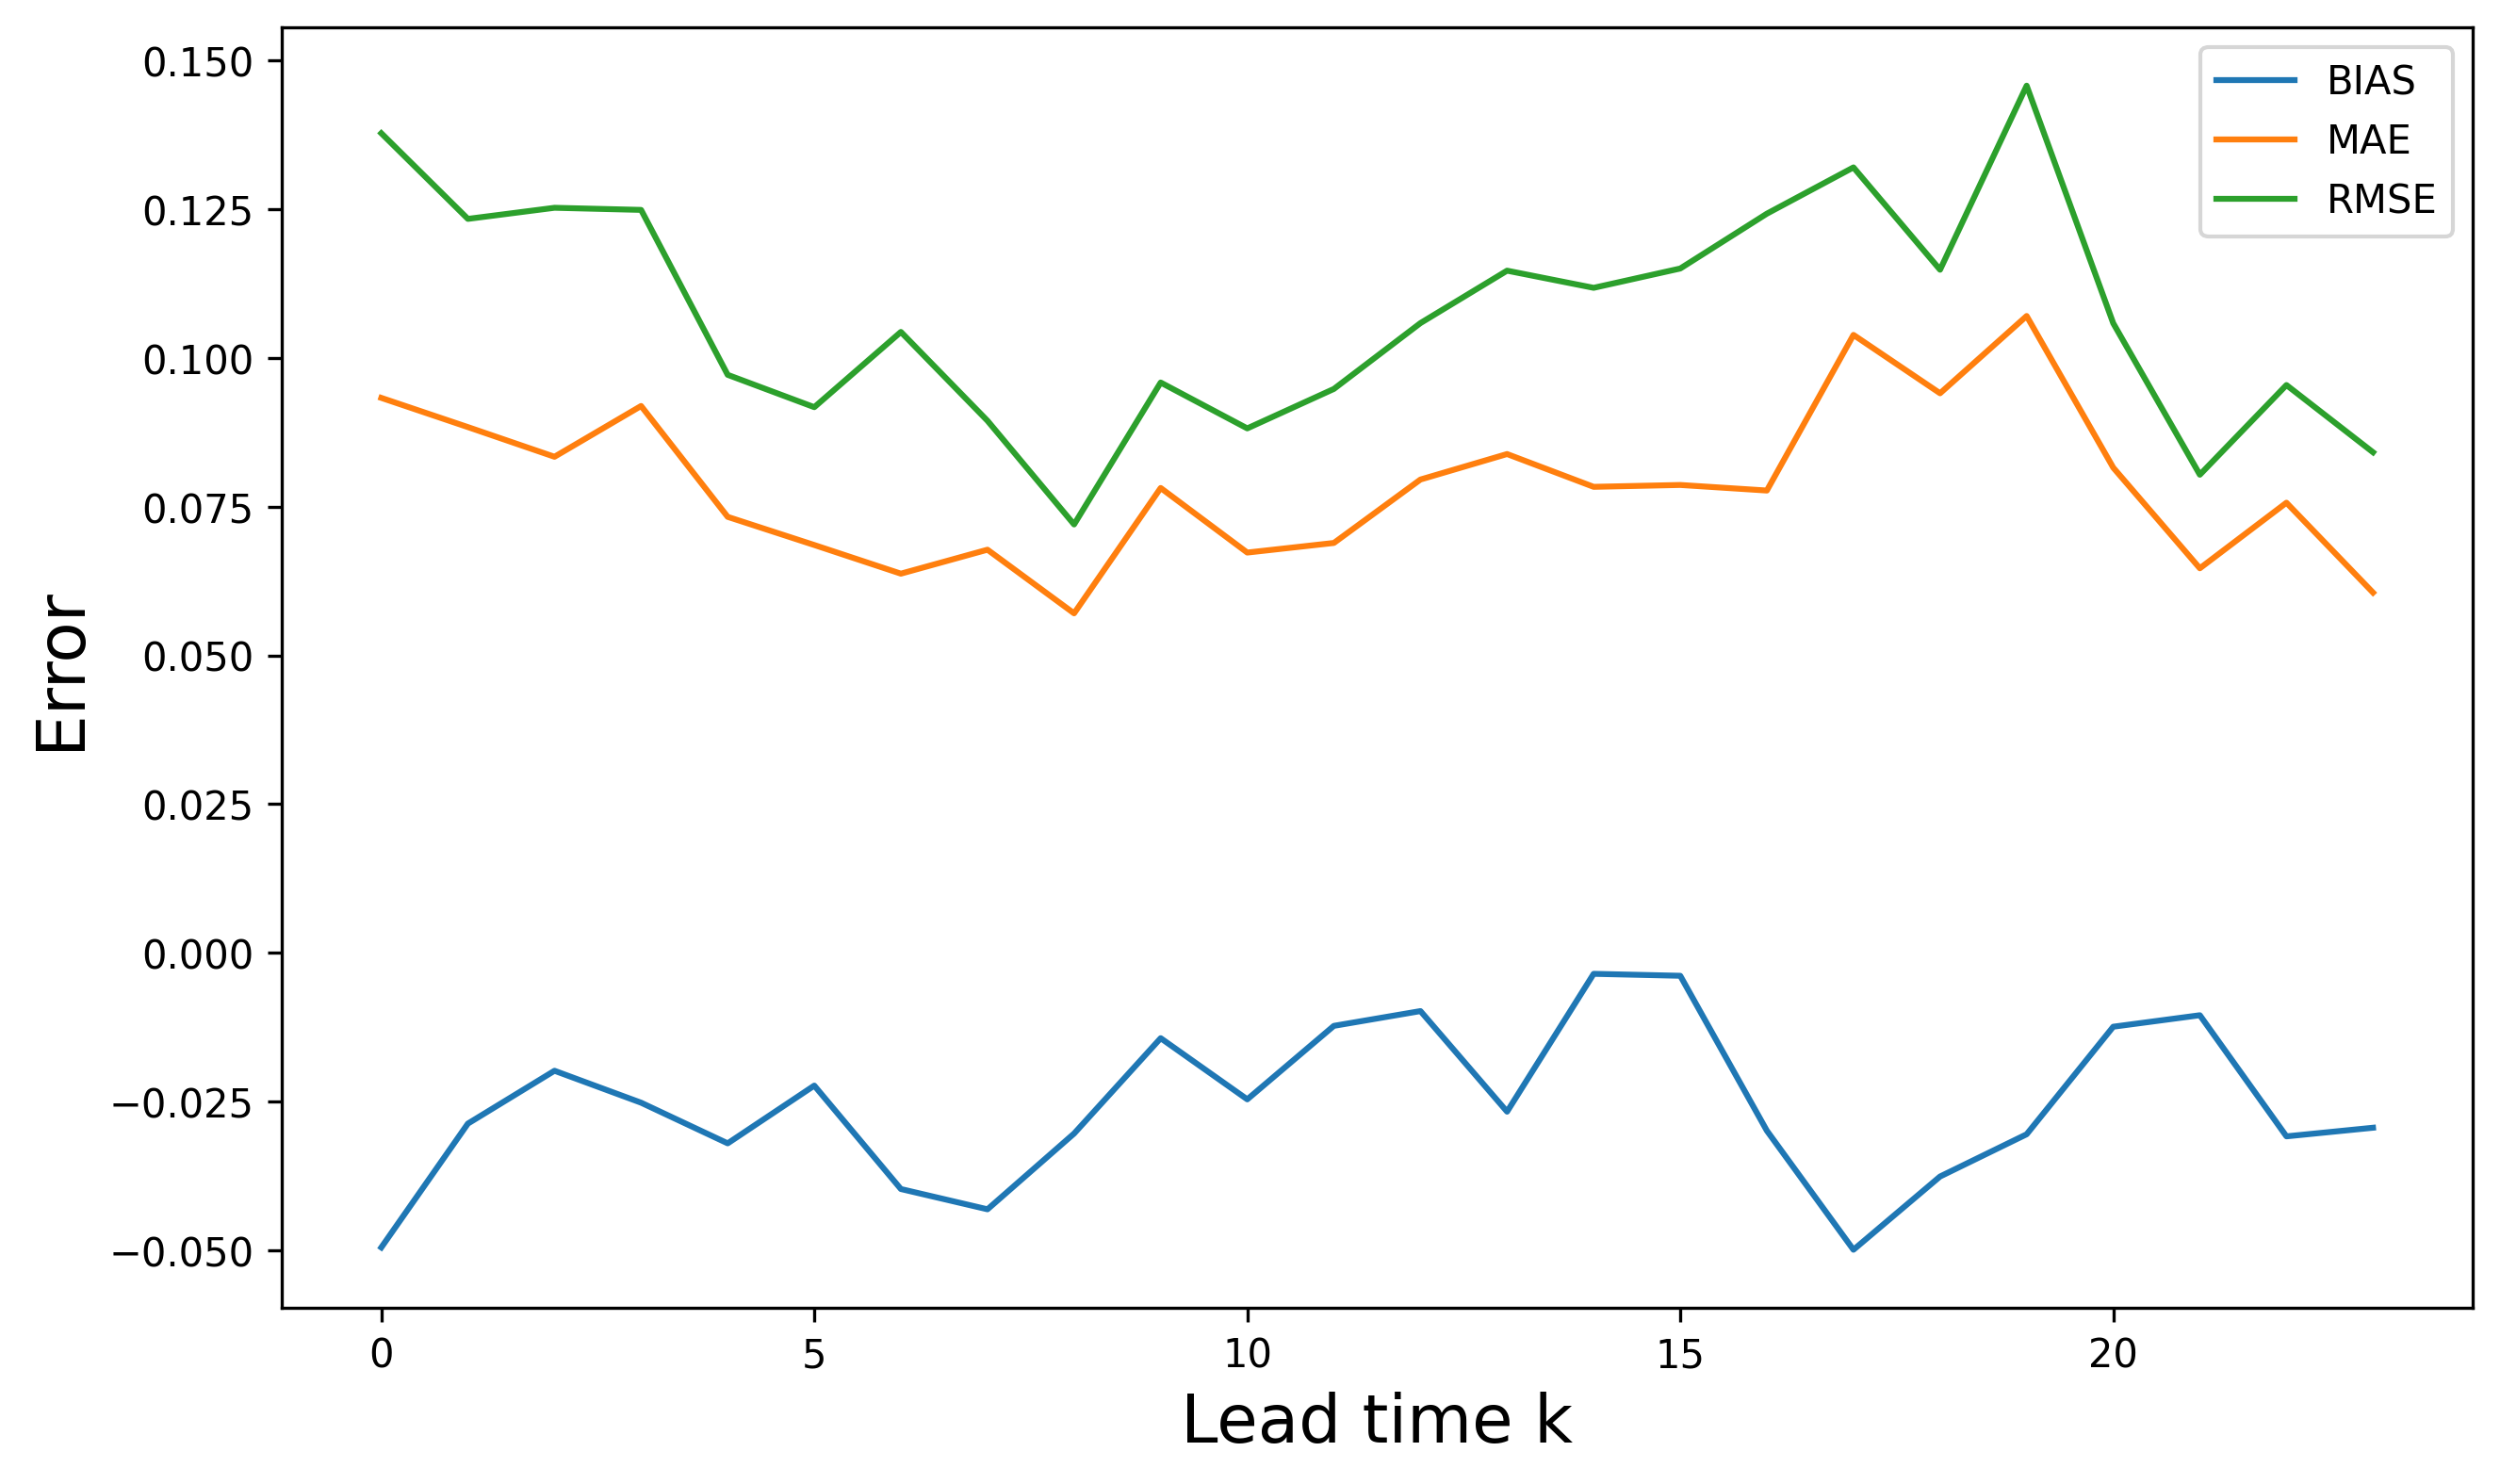

In [0]:
#lead time error
error_leadtime = compute_error2(y_sol, y_hat_cat, weather.hour.values)
plt.figure(figsize=(10,6),dpi=300)
plt.plot(range(0,24), error_leadtime[0], label='BIAS')
plt.plot(range(0,24), error_leadtime[1], label='MAE')
plt.plot(range(0,24), error_leadtime[2], label='RMSE')
plt.xlabel('Lead time k', size=17)
plt.ylabel('Error', size=17)
plt.legend()
plt.savefig('error3.png')

In [0]:
# Merge results
results = [y_hat_lr, y_hat_rlr, y_hat_rr, y_hat_nn, y_hat_blr, y_hat_cat]
labs = ['Linear Regression','Regularized LR', 'Ridge Regression',
              'Neural Network', 'Bayesian LR','Catboost']
residuals = [y_sol - r for r in results]

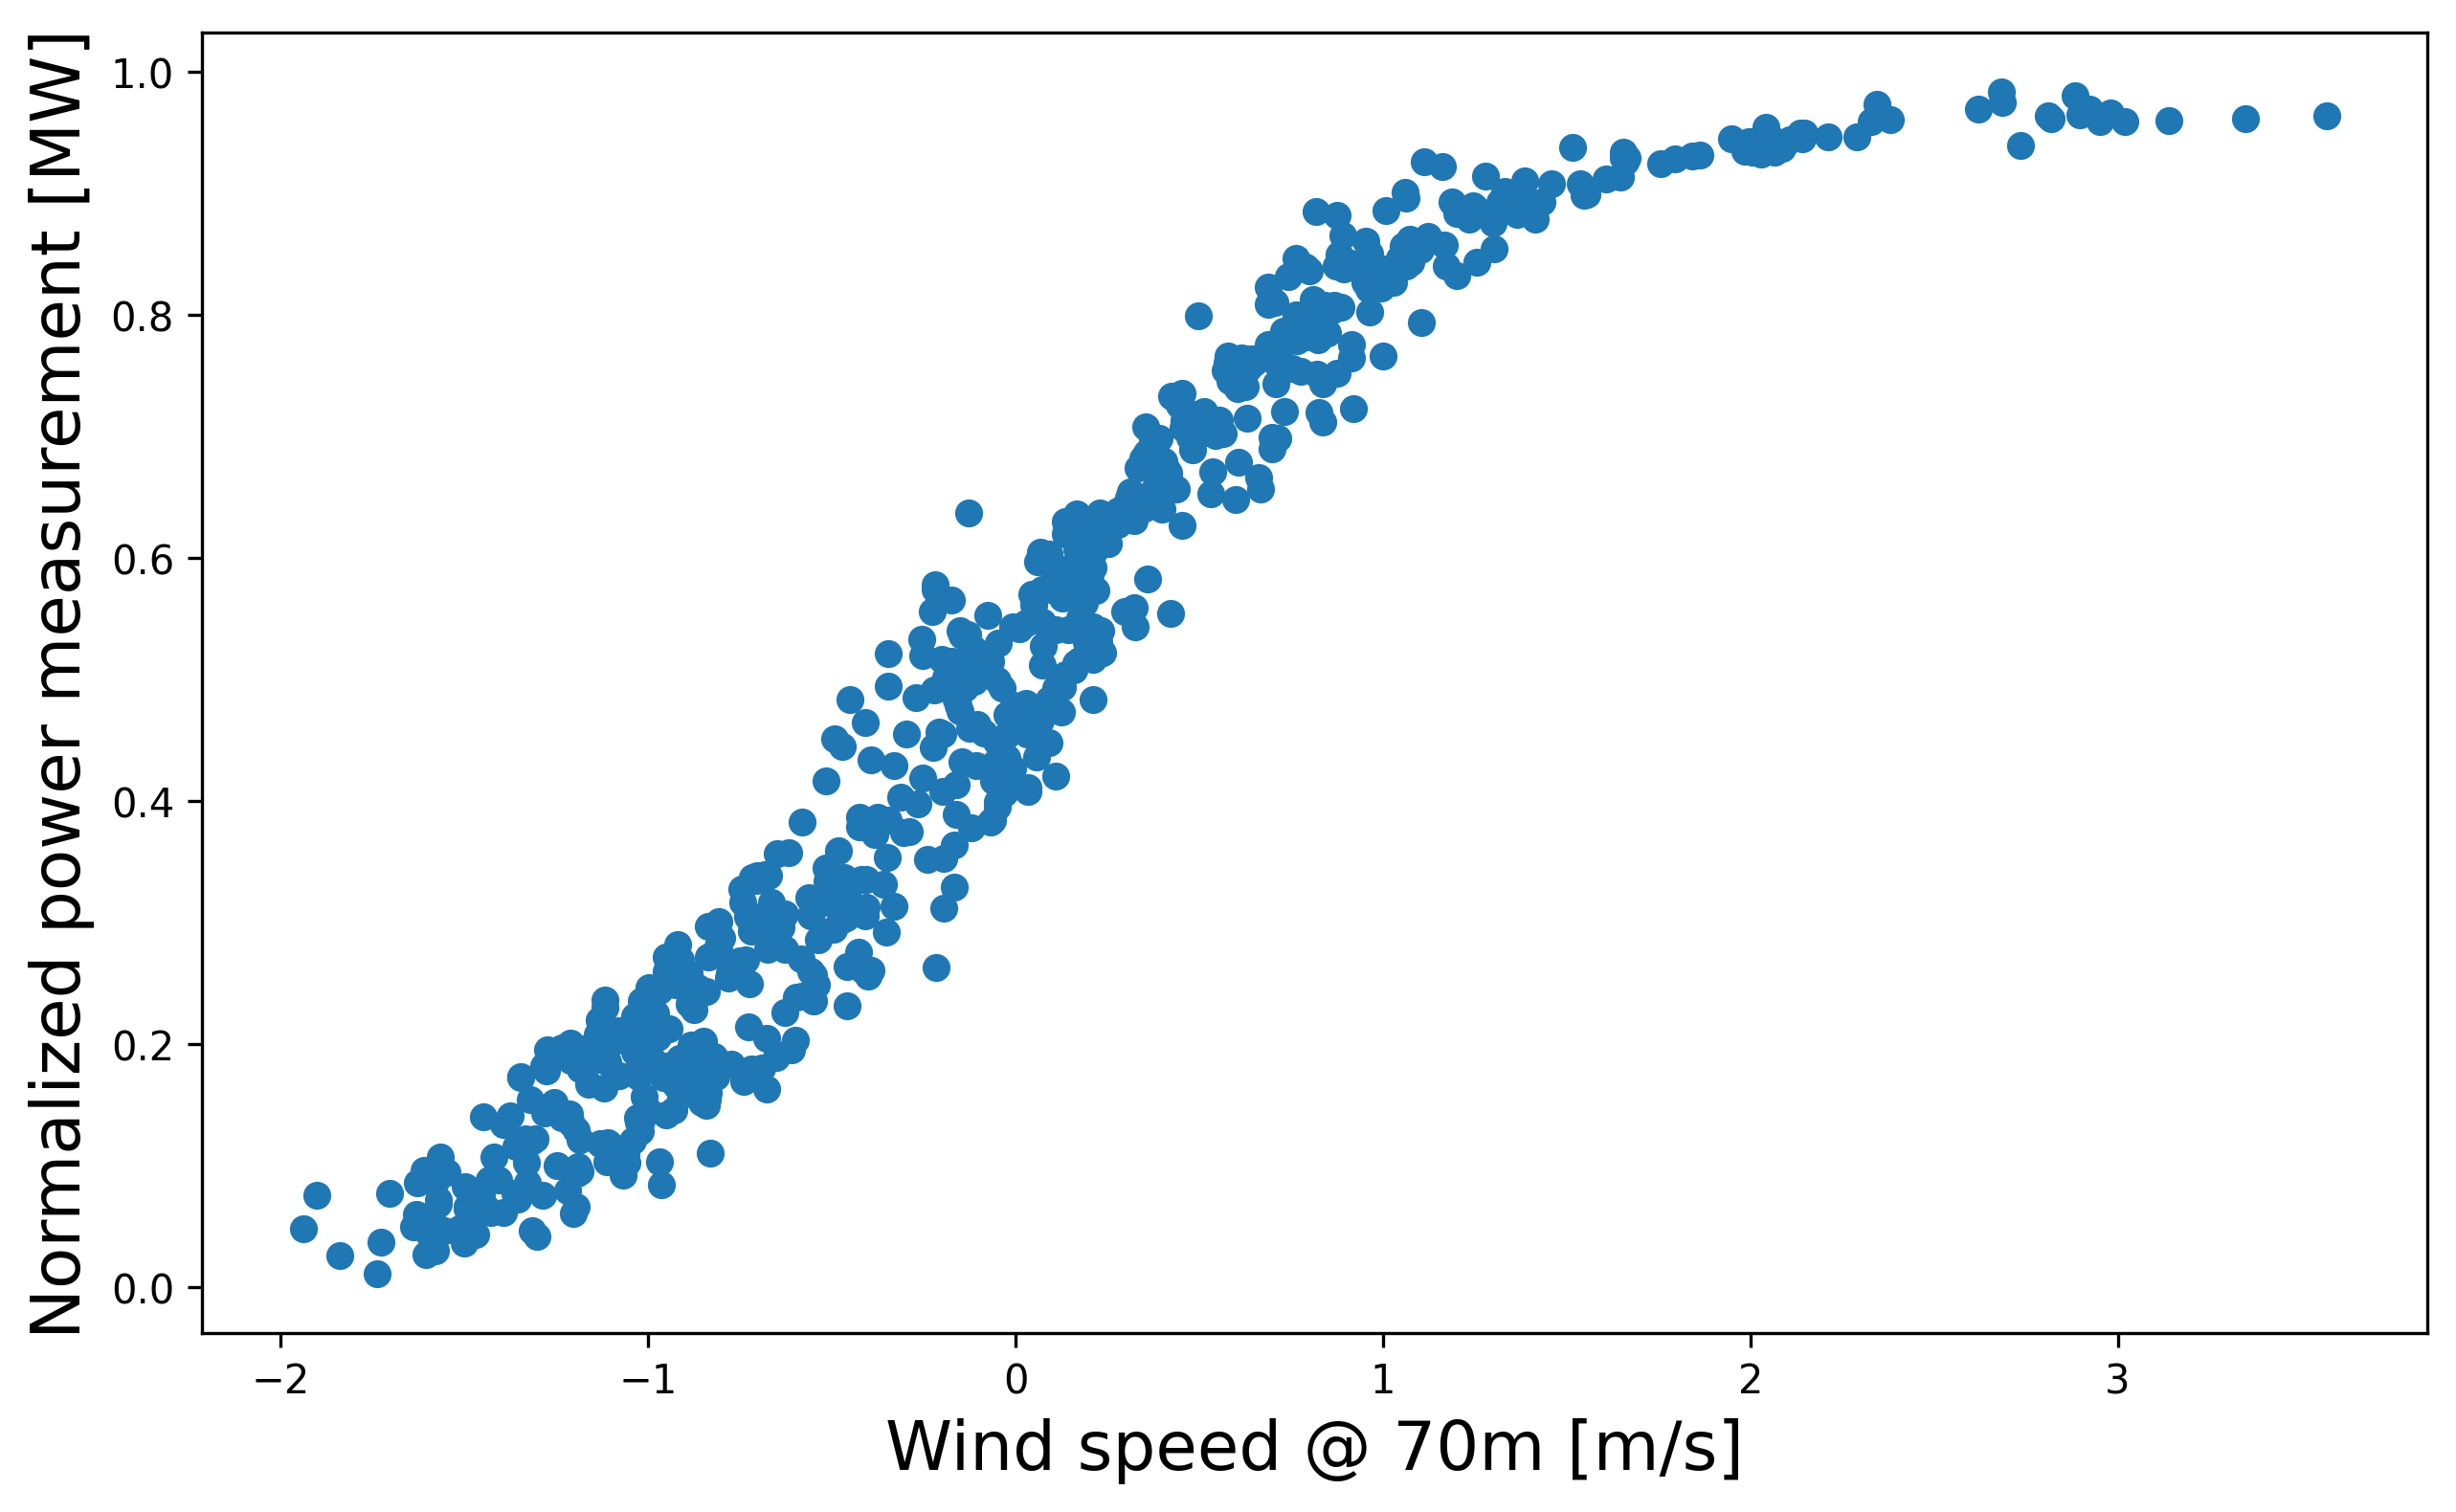

In [0]:
# Solution
plt.figure(figsize=(10,6),dpi=300)
plt.scatter(weather['ws_70'], y_hat_cat)
plt.xlabel('Wind speed @ 70m [m/s]', size=17)
plt.ylabel('Normalized power measurement [MW]', size=17);
plt.savefig('catstage4.png')

In [0]:
# Power vs. wind speed
fig, ax = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(20,8))
p = 0
for i in range(2):
    for j in range(3):
        ax[i, j].scatter(weather['ws_70'], results[p], label=labs[p])
        ax[i,j].legend()
        p+=1

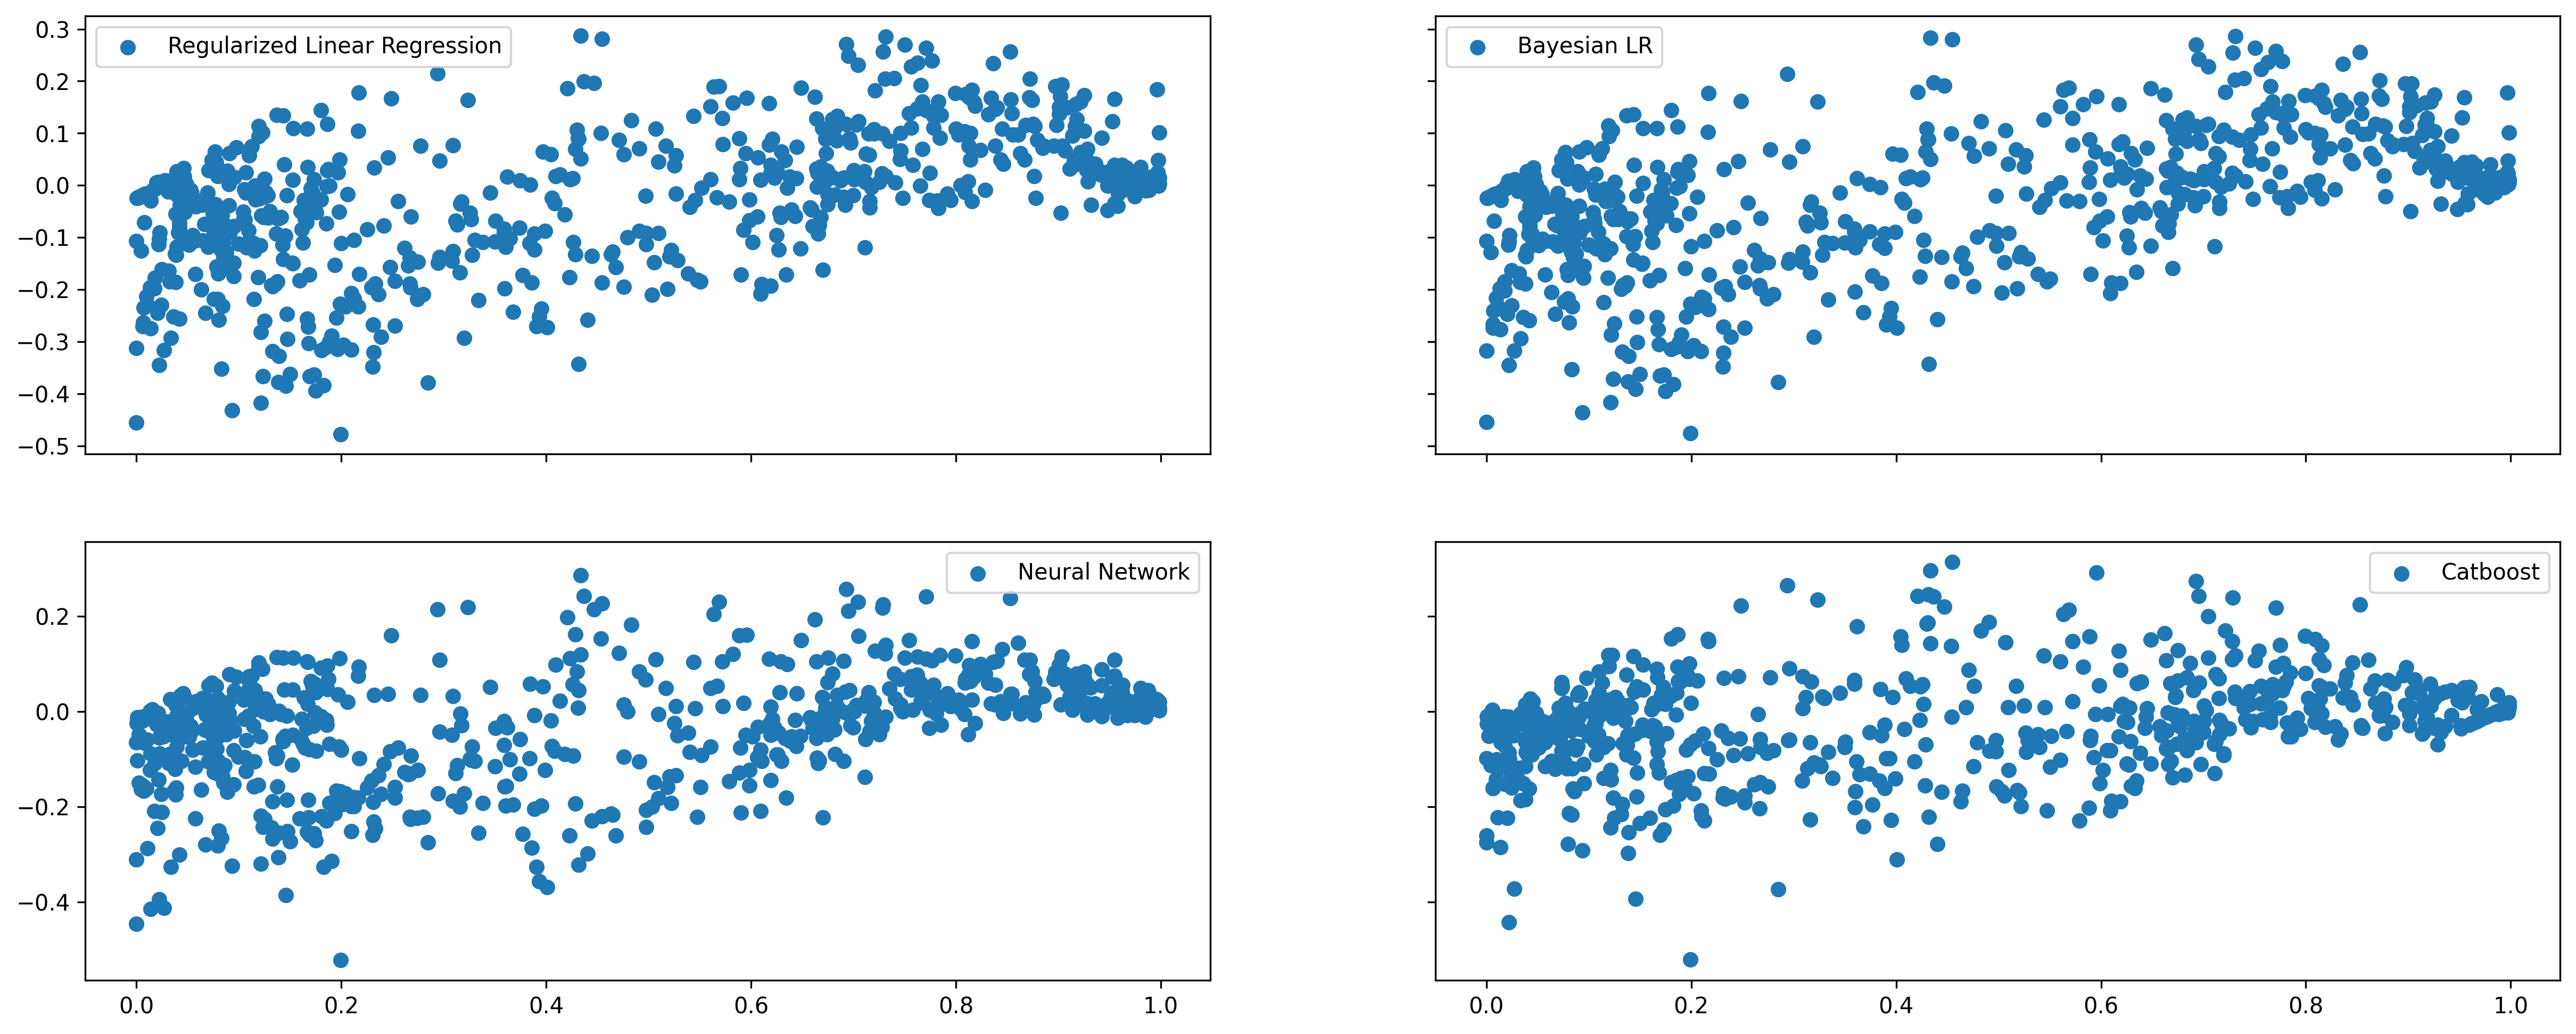

In [0]:
fig, axes = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(20,8), dpi = 300)
p = 0
for i in range(2):
    for j in range(2):
        axes[i,j].scatter(y_sol, residuals[p], label=labs[p])
        axes[i,j].legend()
        p = p+1

plt.savefig('residuals.png')

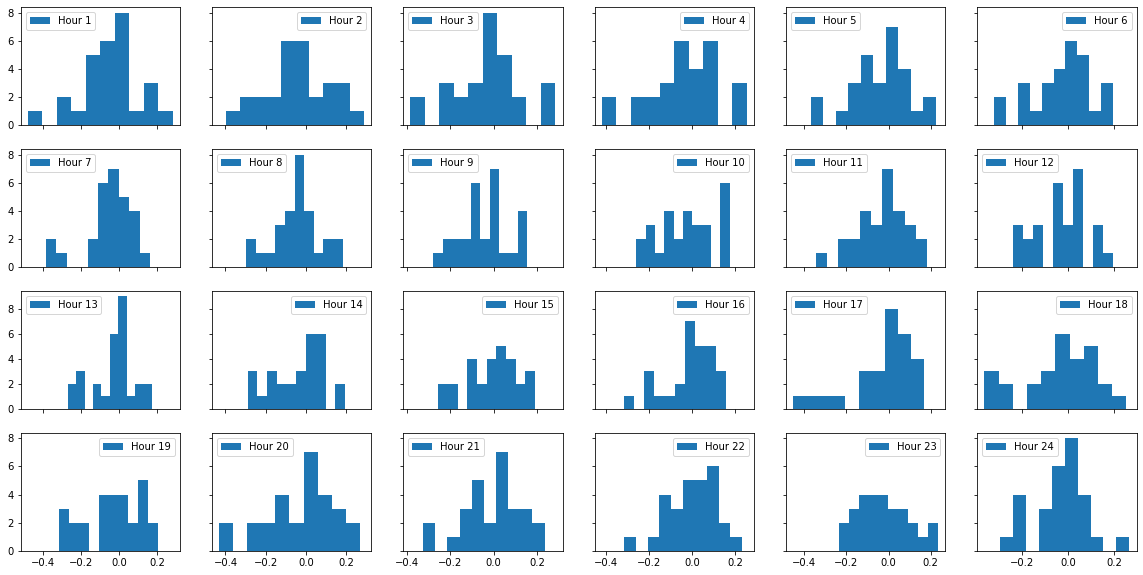

In [0]:
# Distribution of errors
fig, axes = plt.subplots(4, 6, sharex='col', sharey='row', figsize=(20,10))
p = 0
for i in range(4):
    for j in range(6):
        axes[i,j].hist(residuals[4][weather.hour==p+1], label='Hour ' + str(p+1))
        # axes[i,j].axvline(residuals[4][weather.hour==p+1].mean(),
        #                   color='k', linestyle='dashed', linewidth=1, label='Expected[res]')
        axes[i,j].legend()
        p = p+1

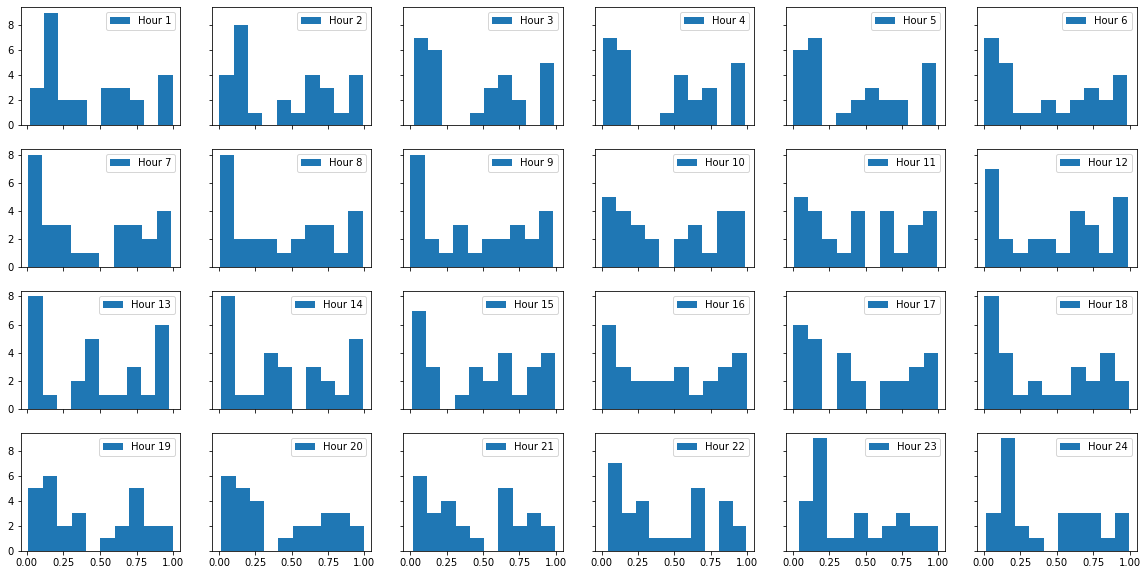

In [0]:
# Distribution of solution
fig, axes = plt.subplots(4, 6, sharex='col', sharey='row', figsize=(20,10))
p = 0
for i in range(4):
    for j in range(6):
        axes[i,j].hist(y_sol[weather.hour==p+1], label='Hour ' + str(p+1))
        # axes[i,j].axvline(residuals[4][weather.hour==p+1].mean(),
        #                   color='k', linestyle='dashed', linewidth=1, label='Expected[res]')
        axes[i,j].legend()
        p = p+1

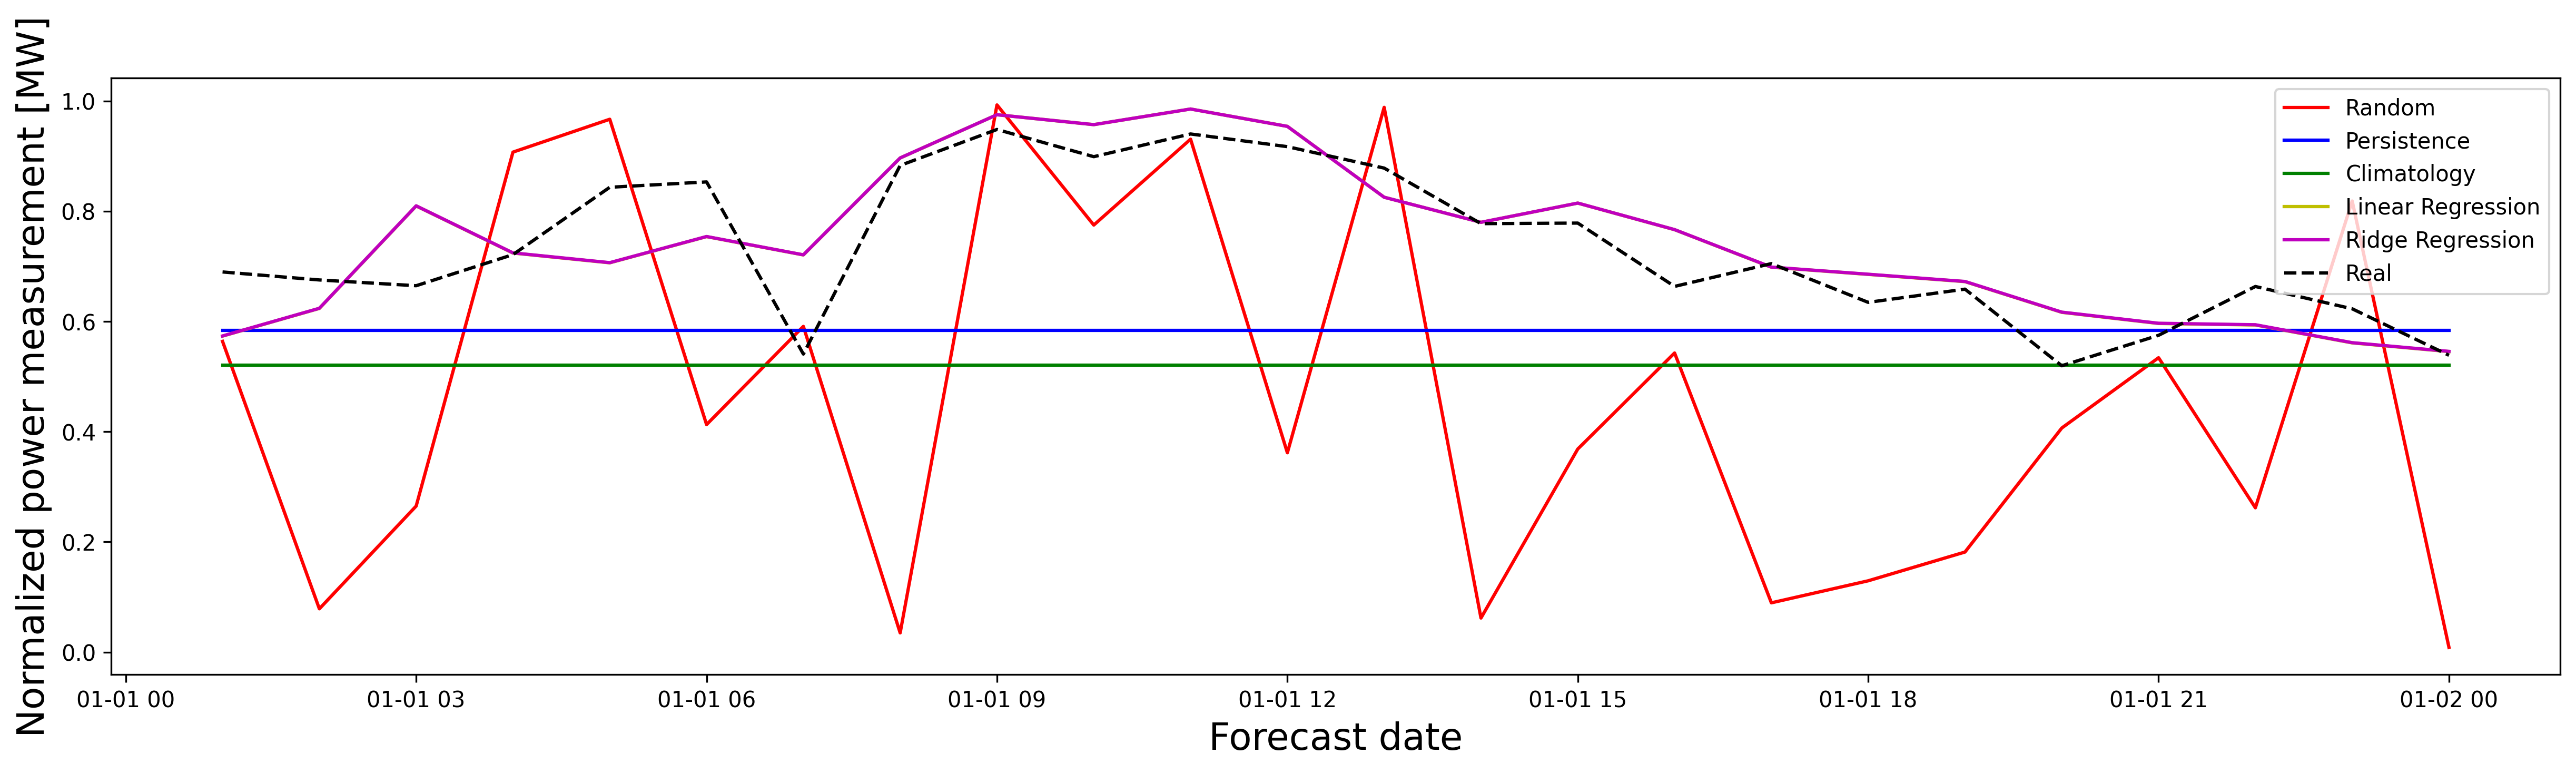

In [0]:
# stage 1 models
plt.figure(figsize=(20,5),dpi=300)
plt.plot(weather.index, y_hat_random, c='r', label='Random')
plt.plot(weather.index, y_hat_pers, c='b', label='Persistence')
plt.plot(weather.index, y_hat_clima, c='g', label='Climatology')
plt.plot(weather.index, y_hat_lr, c='y', label='Linear Regression')
plt.plot(weather.index, y_hat_rr, c='m', label='Ridge Regression')
plt.plot(weather.index, y_sol, 'k--', label='Real')
plt.xlabel('Forecast date',size=17)
plt.ylabel('Normalized power measurement [MW]',size=17)
plt.legend(loc='upper right');
plt.savefig('basecase.png')

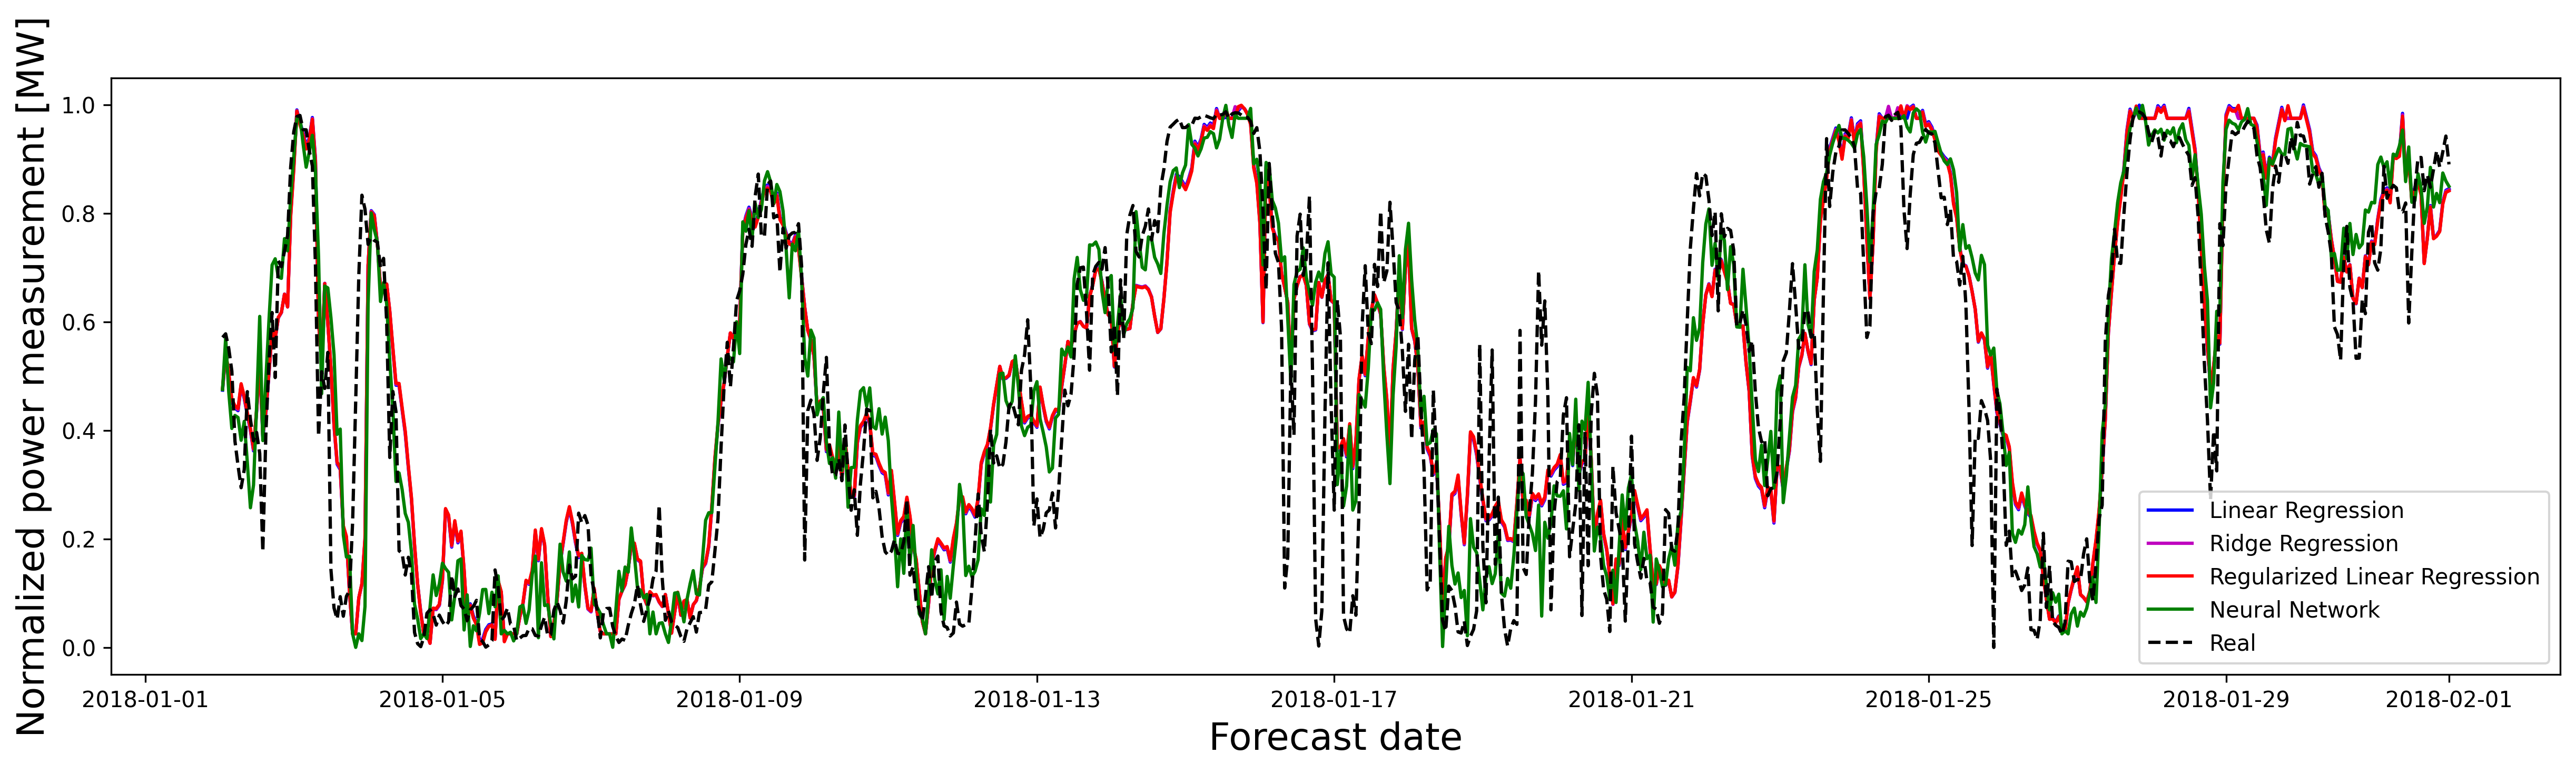

In [0]:
# stage 2 models
plt.figure(figsize=(20,5),dpi=300)
plt.plot(weather.index, y_hat_lr, c='b', label='Linear Regression')
plt.plot(weather.index, y_hat_rr, c='m', label='Ridge Regression')
plt.plot(weather.index, y_hat_rlr, c='r', label='Regularized Linear Regression')
plt.plot(weather.index, y_hat_nn, c='g', label='Neural Network')
plt.plot(weather.index, y_sol, 'k--', label='Real')
plt.xlabel('Forecast date',size=17)
plt.ylabel('Normalized power measurement [MW]',size=17)
plt.legend(loc='lower right');
plt.savefig('stage2.png')

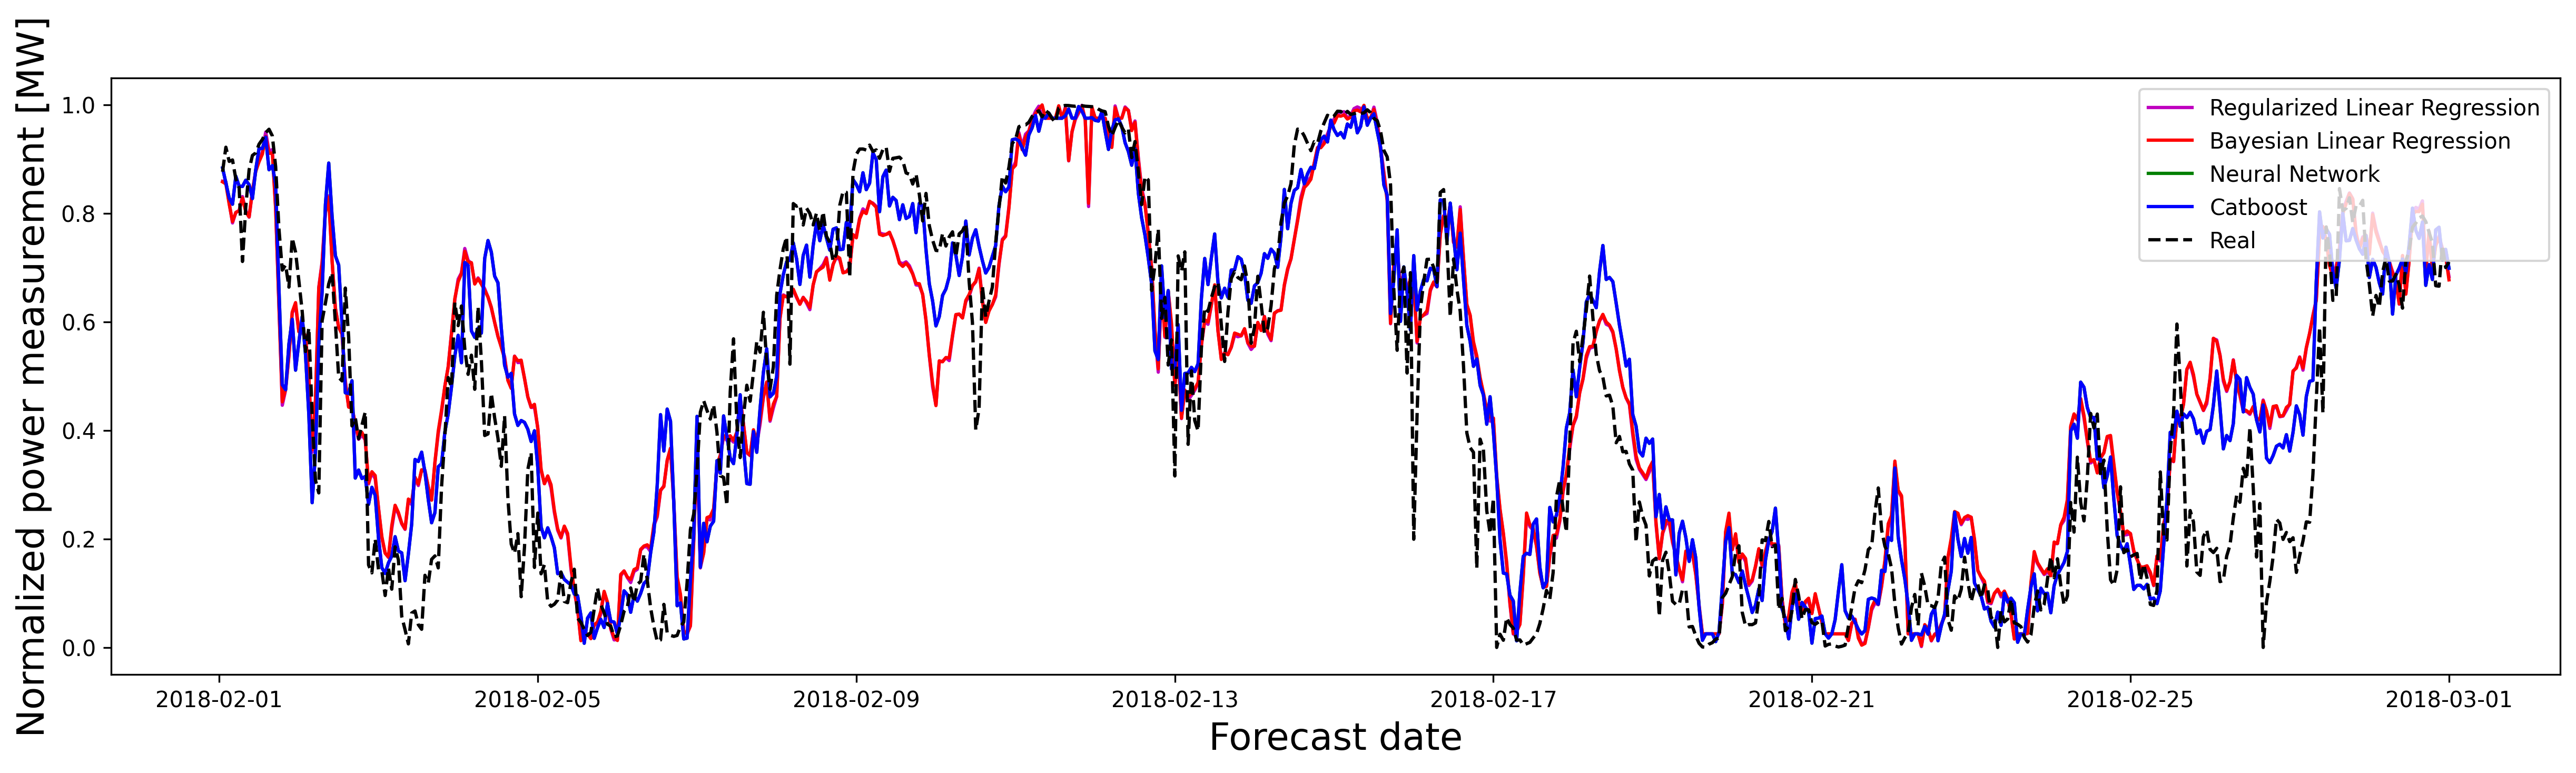

In [0]:
# stage 3 models
plt.figure(figsize=(20,5),dpi=300)
plt.plot(weather.index, y_hat_rlr, c='m', label='Regularized Linear Regression')
plt.plot(weather.index, y_hat_blr, c='r', label='Bayesian Linear Regression')
plt.plot(weather.index, y_hat_nn, c='g', label='Neural Network')
plt.plot(weather.index, y_hat_nn, c='b', label='Catboost')
plt.plot(weather.index, y_sol, 'k--', label='Real')
plt.xlabel('Forecast date',size=17)
plt.ylabel('Normalized power measurement [MW]',size=17)
plt.legend(loc='upper right');
plt.savefig('stage3.png')

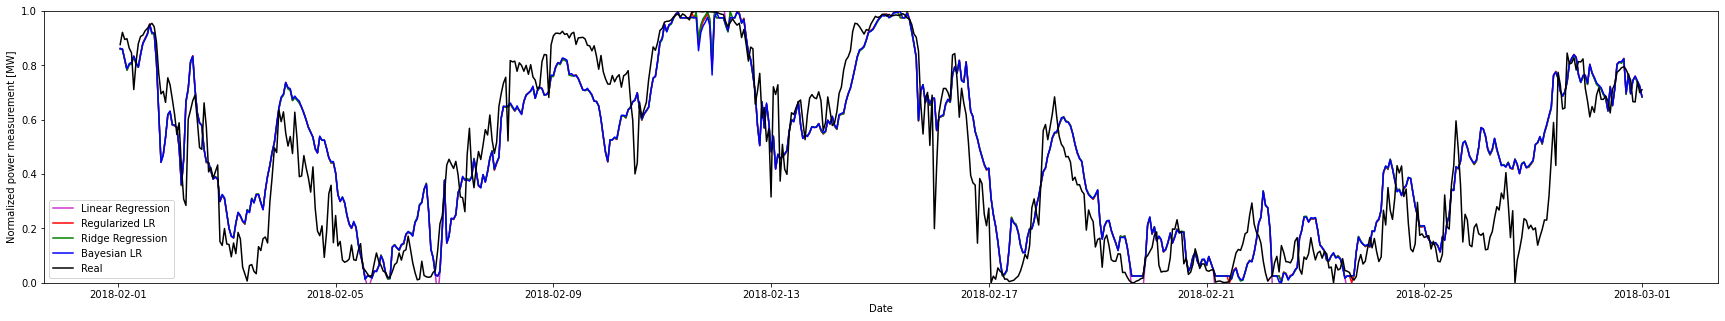

In [0]:
# 'Normal' regressions
plt.figure(figsize=(30,5))
plt.plot(weather.index, y_hat_lr, label='Linear Regression', c='m', alpha=0.8)
plt.plot(weather.index, y_hat_rlr, label='Regularized LR', c='r')
plt.plot(weather.index, y_hat_rr, label='Ridge Regression', c='g')
plt.plot(weather.index, y_hat_blr, label='Bayesian LR', c='b')
plt.plot(weather.index, y_sol, label='Real', c='k')
plt.xlabel('Date')
plt.ylabel('Normalized power measurement [MW]')
plt.legend()
plt.ylim(0,1);

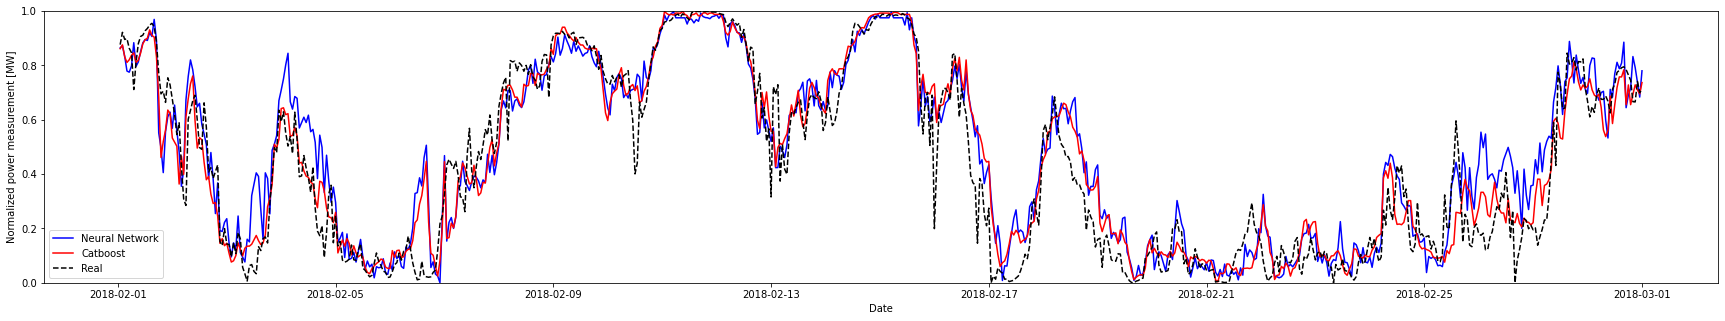

In [0]:
# Complex models
plt.figure(figsize=(30,5))
plt.plot(weather.index, y_hat_nn, label='Neural Network', c='b')
plt.plot(weather.index, y_hat_cat, label='Catboost', c='r')
plt.plot(weather.index, y_sol, 'k--', label='Real')
plt.xlabel('Date')
plt.ylabel('Normalized power measurement [MW]')
plt.legend()
plt.ylim(0,1);

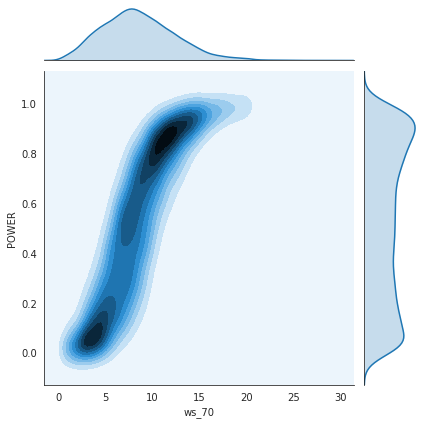

In [0]:
with sns.axes_style('white'):
    sns.jointplot(train.ws_70, train.POWER, kind='kde');

In [0]:
# 1 in, 2 hidden, 1 out K=10
for net in nets:
    y_hat_nn = net(torch.tensor(X_predict, dtype=torch.float))
    y_hat_nn = y_hat_nn.detach().numpy().flatten()
    estimates = [0.975 if y_hat > 1 else 0.025 if y_hat < 0 else y_hat for y_hat in y_hat_nn]
    y_hat_nn = np.array(estimates)
    print(compute_error(y_sol, y_hat_nn))

[-0.029295990236624315, 0.09863652400395208, 0.14811284875031291, 0.7996102839768071]
[-0.02426314525648049, 0.09907923452853527, 0.14734695576655116, 0.8016773600351003]
[-0.031045642194341517, 0.0970982592915629, 0.14341367094107718, 0.8121241040396577]
[-0.027823437668386512, 0.1008474786001367, 0.14888463115547004, 0.7975164723969974]
[-0.02680319342690134, 0.09911335688316274, 0.1471090545490468, 0.8023172525759296]
[-0.029934793055992233, 0.09839341731997882, 0.14698193374096022, 0.8026587506992615]
[-0.02746046722070134, 0.097277428466716, 0.14502381510059503, 0.8078817547545893]
[-0.027283385006196866, 0.09902249089269814, 0.14635605619062225, 0.8043358070108507]
[-0.03246980914360043, 0.10151187734162717, 0.14887601621862012, 0.7975399043969582]
[-0.027394013497257483, 0.09637000664687773, 0.14493925244808625, 0.8081057357871326]


In [0]:
# 1 in, 1 hidden, 1 out K=10
for net in nets:
    y_hat_nn = net(torch.tensor(X_predict, dtype=torch.float))
    y_hat_nn = y_hat_nn.detach().numpy().flatten()
    estimates = [0.975 if y_hat > 1 else 0.025 if y_hat < 0 else y_hat for y_hat in y_hat_nn]
    y_hat_nn = np.array(estimates)
    print(compute_error(y_sol, y_hat_nn))

[-0.023983606245268633, 0.1005224674077966, 0.14660072824808795, 0.8036810534127197]
[-0.025717897249647813, 0.09819079520997825, 0.14515802002726508, 0.8075260180794658]
[-0.025922207750900813, 0.09983054926837409, 0.14688850139822704, 0.8029095596863323]
[-0.027504473233702337, 0.09782352501227977, 0.14627610723939757, 0.8045495169834986]
[-0.027577471252223748, 0.09921704968054919, 0.14763799794966784, 0.8008931258606755]
[-0.028310636378517662, 0.09800245686783858, 0.147229783994919, 0.8019926509141989]
[-0.027055077067786693, 0.09712162711052573, 0.1442875183017179, 0.8098276000957977]
[-0.026441179395242775, 0.09745766543786595, 0.14544331334914837, 0.8067686985294682]
[-0.026426004820506672, 0.1003705919817028, 0.14721040079268613, 0.8020447838963188]
[-0.02629875939526002, 0.09910272578458759, 0.14628824781122146, 0.8045170717791024]


In [0]:
# Compute errors (model vs. solution)
#e_random = compute_error(y_sol, y_hat_random, weather.hour.values)
#e_pers = compute_error(y_sol, y_hat_pers, weather.hour.values)
#e_clima = compute_error(y_sol, y_hat_clima, weather.hour.values)
#e_lr = compute_error(y_sol, y_hat_lr, weather.hour.values)
#e_rlr = compute_error(y_sol, y_hat_rlr, weather.hour.values)
#e_rr = compute_error(y_sol, y_hat_rr, weather.hour.values)
#e_nn = compute_error(y_sol, y_hat_nn, weather.hour.values)
#e_blr = compute_error(y_sol, y_hat_blr, weather.hour.values)
e_cat = compute_error(y_sol, y_hat_cat, weather.hour.values)
# e_bnnet = compute_error(y_sol, y_hat_bnn, weather.hour.values)
#e_bid = compute_error(y_sol, bid.FORECAST, weather.hour.values)
#errors = [e_random, e_pers, e_clima, e_lr, e_rr]
errors = [e_cat]
#errors = [e_random, e_pers, e_clima, e_lr, e_rlr, e_rr, e_nn, e_blr, e_cat, e_bid]
# errors = [e_random, e_pers, e_clima, e_lr, e_rlr, e_rr, e_nn, e_blr, e_cat, e_bnn, e_bid]

In [0]:
# Save errors to DataFrame and show
df_results = pd.DataFrame(data=errors,
                          index=['Random',
                                 'Persistence',
                                 'Climatology',
                                 'Linear Regression',
                                 'Ridge Regression'],
                          columns=['BIAS', 'MAE', 'RMSE', 'R2'])
df_results

BIAS       MAE      RMSE   R2
Random             0.263247  0.322401  0.322401  0.0
Persistence        0.149278  0.162677  0.162677  0.0
Climatology        0.212292  0.212380  0.212380  0.0
Linear Regression -0.010153  0.059760  0.059760  0.0
Ridge Regression  -0.010338  0.059788  0.059788  0.0

In [0]:
# Save errors to DataFrame and show - stage 2
df_results = pd.DataFrame(data=errors,
                          index= ['Linear Regression',
                                  'Regularized Linear Regression',
                                  'Ridge Regression',
                                  'Neural Network'],
                          columns=['BIAS', 'MAE', 'RMSE', 'R2'])
df_results

BIAS       MAE      RMSE        R2
Linear Regression             -0.030441  0.103860  0.141952  0.807409
Regularized Linear Regression -0.030959  0.104337  0.142444  0.806255
Ridge Regression              -0.030664  0.104055  0.142207  0.806789
Neural Network                -0.028646  0.099431  0.142560  0.800167

In [0]:
# Save errors to DataFrame and show - stage 3
df_results = pd.DataFrame(data=errors,
                          index= ['Regularized Linear Regression',
                                  'Bayesian Linear Regression',
                                  'Neural Network',
                                  'Catboost'],
                          columns=['BIAS', 'MAE', 'RMSE', 'R2'])
df_results

BIAS       MAE      RMSE        R2
Regularized Linear Regression -0.030557  0.104633  0.137634  0.822211
Bayesian Linear Regression    -0.031434  0.105158  0.138106  0.821022
Neural Network                -0.035516  0.090795  0.123064  0.857716
Catboost                      -0.027449  0.079767  0.107856  0.889642

In [0]:
# Save errors to DataFrame and show - stage 4
df_results = pd.DataFrame(data=errors,
                          index= ['Catboost'],
                          columns=['BIAS', 'MAE', 'RMSE', 'R2'])
df_results

BIAS       MAE      RMSE        R2
Catboost -0.025716  0.078654  0.107311  0.890836

In [0]:
# Save errors to DataFrame and show
df_results = pd.DataFrame(data=errors,
                          index=['Random',
                                 'Persistence',
                                 'Climatology',
                                 'Linear Regression',
                                 'Regularized LR',
                                 'Ridge Regression',
                                 'Neural Network',
                                 'Bayesian LR',
                                 'Catboost',
                                 'Bid'],
                          columns=['BIAS', 'MAE', 'RMSE', 'R2'])
df_results

BIAS       MAE      RMSE        R2
Random            -0.063878  0.382868  0.454013  0.000181
Persistence       -0.472359  0.483608  0.576832  0.000000
Climatology       -0.076875  0.306862  0.339985  0.000000
Linear Regression -0.029078  0.106422  0.138246  0.820762
Regularized LR    -0.030192  0.104304  0.137349  0.822912
Ridge Regression  -0.030525  0.104609  0.137607  0.822277
Neural Network    -0.036295  0.090434  0.124038  0.854628
Bayesian LR       -0.030731  0.104788  0.137807  0.821691
Catboost          -0.015324  0.075873  0.103338  0.898141
Bid               -0.027449  0.079767  0.107856  0.889642

In [0]:
compute_error(y_sol, y_hat_cat, weather.hour.values)

[-0.028672840764417323,
 0.0809718138811193,
 0.10813815028715223,
 0.8891183970203729]

# Selection and export

In [0]:
# Export selected model estimates to csv
template.FORECAST = y_hat_cat # change to selected model
template.to_csv('31761-Holmsbu_United-stage4.csv')
files.download('31761-Holmsbu_United-stage4.csv')

# Descriptive Statistics

In [0]:
# Simple
train_raw.describe()

POWER           U10           V10          U100          V100
count  25846.000000  25846.000000  25846.000000  25846.000000  25846.000000
mean       0.520661      2.333311      0.615427      3.182113      0.937819
std        0.312567      5.066028      4.469468      6.963827      6.133418
min        0.000000    -11.649200    -18.724500    -15.922300    -25.071400
25%        0.235322     -1.652047     -2.630875     -2.028030     -3.544365
50%        0.542307      2.840925      0.655644      3.993190      0.905614
75%        0.812662      6.063060      3.747397      8.248765      5.242762
max        1.000000     21.876300     16.076300     31.050900     22.310800

In [0]:
# Simple
weather.describe()

wd_70      ws_70
count   24.000000  24.000000
mean   240.901034  12.306439
std     16.391141   2.009938
min    207.371760   9.390140
25%    232.691513  10.716627
50%    248.318479  12.119471
75%    251.253502  13.189690
max    263.575437  17.387105

In [0]:
# Automated reports
profile_train = ProfileReport(train,
                             title='Training data',
                              html={'style':{'full_width':True}},
                              reject_variables=False,
                              progress_bar=True)
profile_weather = ProfileReport(weather,
                             title='Weather data',
                             html={'style':{'full_width':True}},
                             reject_variables=False,
                             progress_bar=True)

# # Save reports to html format
# profile_train.to_file(output_file="train.html")
# profile_weather.to_file(output_file="weather.html")

# # Export reports
# files.download('train.html')
# files.download('weather.html')

In [0]:
profile_train.to_notebook_iframe()

In [0]:
profile_weather.to_notebook_iframe()

# Data Visualization

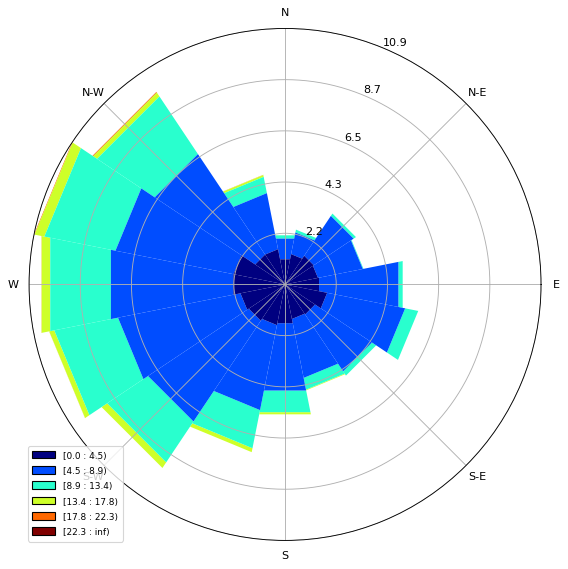

In [0]:
# Wind rose ('from' convention)
plot_windrose(train['wd_10'], train['ws_10'])
plot_windrose(train['wd_100'], train['ws_100'])
plot_windrose(train['wd_70'], train['ws_70'])

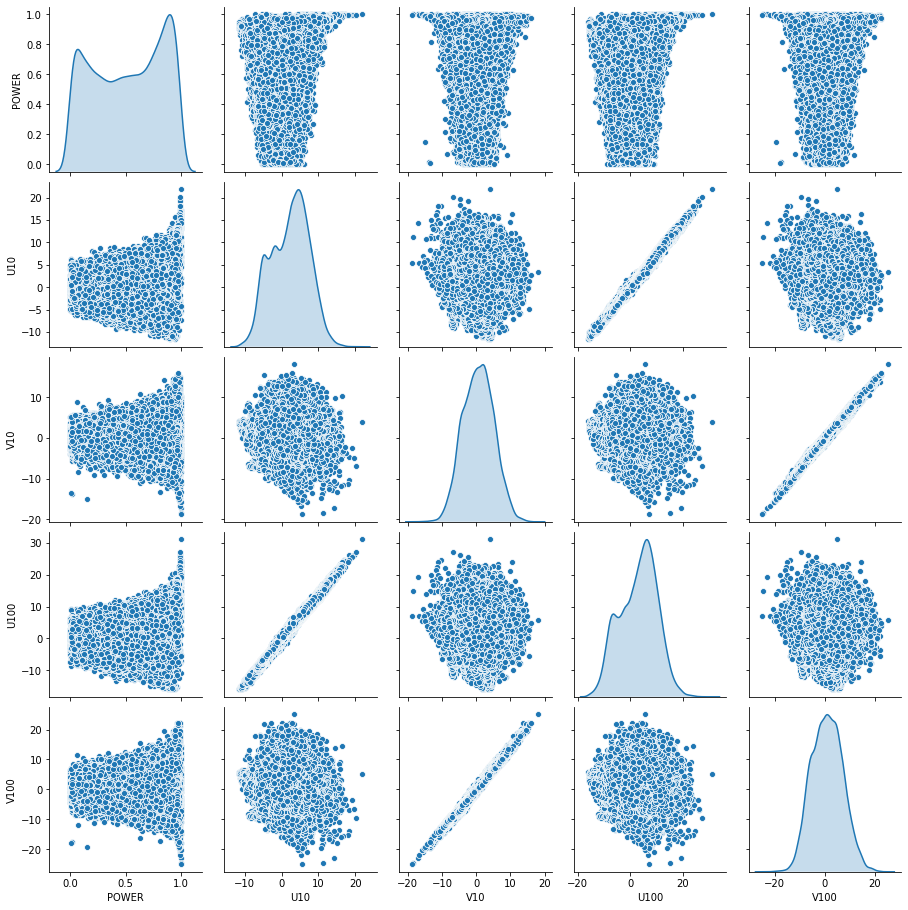

In [0]:
# Pairplot of variables
sns.pairplot(train_raw, palette="husl", diag_kind="kde")

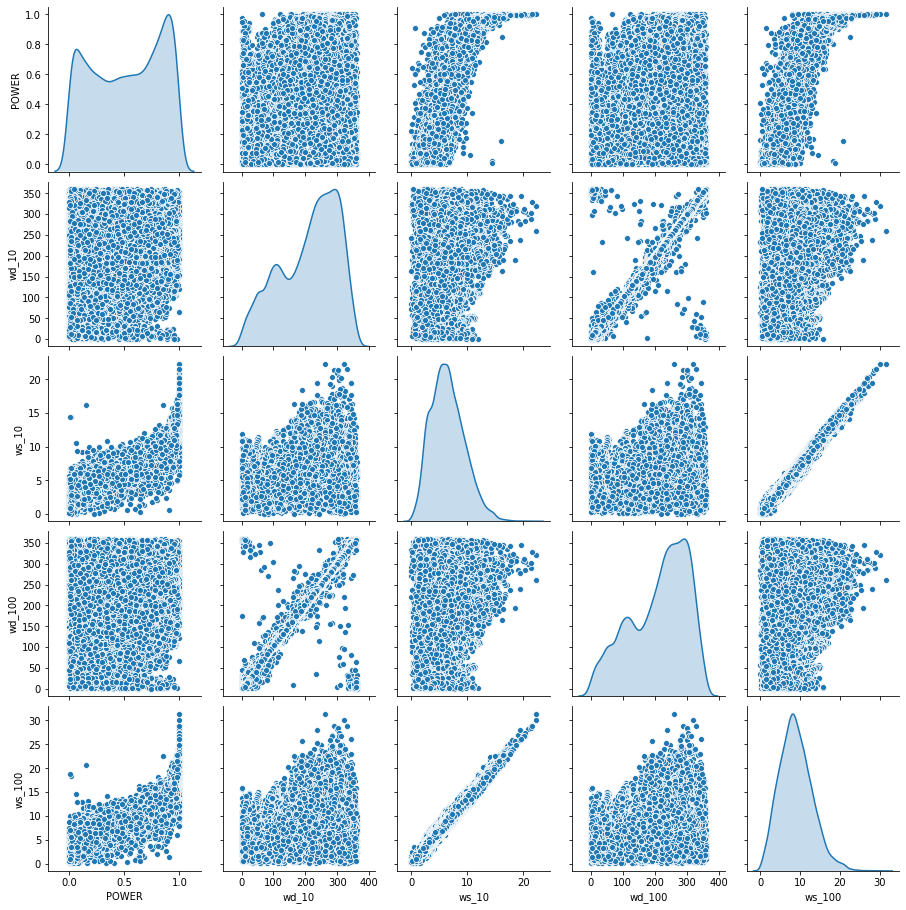

In [0]:
# Pairplot of variables
sns.pairplot(train_dataviz,
             vars=['POWER', 'wd_10', 'ws_10', 'wd_100', 'ws_100'],
             palette="husl",
             diag_kind="kde")

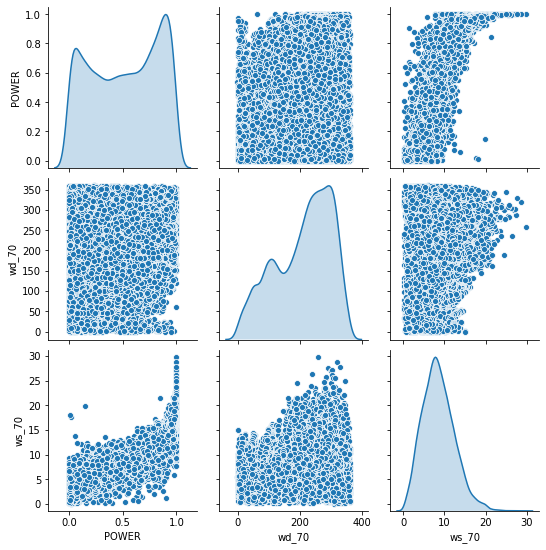

In [0]:
# Pairplot of variables
sns.pairplot(train, palette="husl", diag_kind="kde")

Expected value of α:  0.13689378746448455


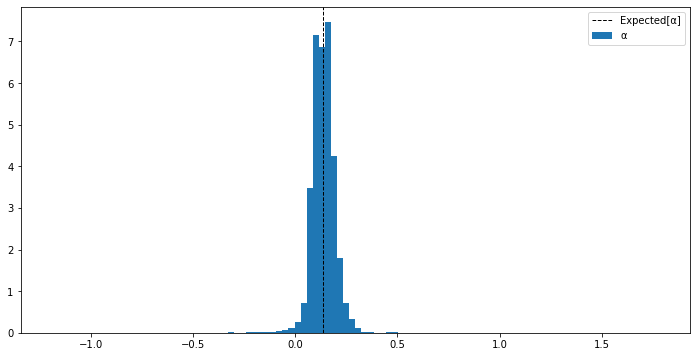

In [0]:
# Alpha distribution
plt.figure(figsize=(12,6))
plt.hist(α_train, bins=100, density=True, label ='α');
plt.axvline(α_train.mean(), color='k', linestyle='dashed', linewidth=1, label='Expected[α]')
plt.legend()
print('Expected value of α: ', α_train.mean())

Expected value of α:  0.13289214290382423


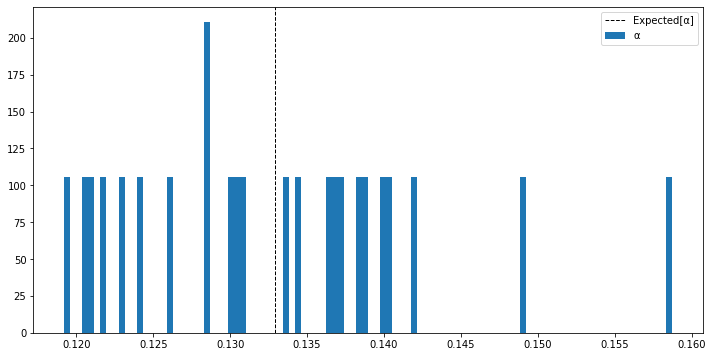

In [0]:
# Alpha distribution
plt.figure(figsize=(12,6))
plt.hist(α_weather, bins=100, density=True, label ='α');
plt.axvline(α_weather.mean(),
            color='k',
            linestyle='dashed',
            linewidth=1,
            label='Expected[α]')
plt.legend()
print('Expected value of α: ', α_weather.mean())

alpha:  0.1765765460763109 wd_10:  10.147756475995076 . ws_70:  14.308513894011927 . wd_100:  15.238653098289232


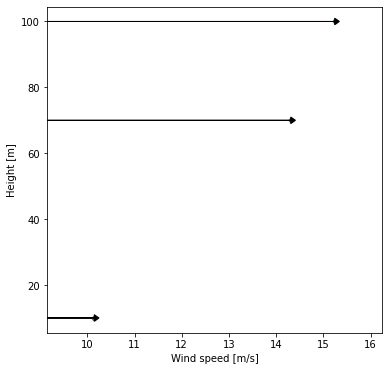

In [0]:
# Wind speed profile
i = 2000
ax = plt.figure(figsize=(6,6))
ax = sns.scatterplot([train_dataviz['ws_10'][i],
             train_dataviz['ws_70'][i],
             train_dataviz['ws_100'][i]],
            [10, 70, 100],
            markers=False)
ax.arrow(train_dataviz['ws_10'][i] - 1,
         10,
         1,
         0,
         head_width=2,
         head_length=0.1,
         fc='black',
         ec='black')
ax.arrow(train_dataviz['ws_10'][i] - 1,
         70,
         train_dataviz['ws_70'][i] - train_dataviz['ws_10'][i] + 1,
         0,
         head_width=2,
         head_length=0.1,
         fc='black',
         ec='black')
ax.arrow(train_dataviz['ws_10'][i] - 1,
         100,
         train_dataviz['ws_100'][i] - train_dataviz['ws_10'][i] + 1,
         0,
         head_width=2,
         head_length=0.1,
         fc='black',
         ec='black')
ax.set_xlim(train_dataviz['ws_10'][i] - 1, train_dataviz['ws_100'][i] + 1)
ax.set_xlabel('Wind speed [m/s]')
ax.set_ylabel('Height [m]')

print('alpha: ', α_train[i],
      'wd_10: ', train_dataviz['ws_10'][i],
      '. ws_70: ', train_dataviz['ws_70'][i],
      '. wd_100: ', train_dataviz['ws_100'][i])

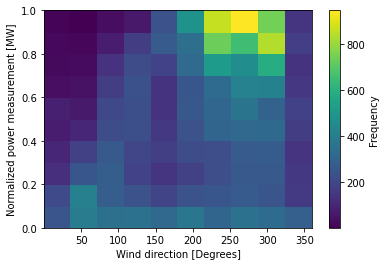

In [0]:
fig, ax = plt.subplots()
h = ax.hist2d(train.wd_70, train.POWER, bins=10)
cbar = plt.colorbar(h[3], ax=ax);
cbar.set_label('Frequency')
plt.xlabel('Wind direction [Degrees]')
plt.ylabel('Normalized power measurement [MW]');

# PyCaret

In [0]:
# See https://github.com/pycaret/pycaret/blob/master/regression.py

In [0]:
reg1 = setup(data = train, target = 'POWER', session_id=123,
             categorical_features=['month', 'hour'], normalize = True
             )

 
Setup Succesfully Completed!


In [0]:
# Compare models to get estimate of best ones
compare_models()

In [0]:
# Create ndividual models
cat = create_model('catboost')
lgbm = create_model('lightgbm')
rf = create_model('rf')
xgb = create_model('xgboost')

In [0]:
# Blend individual modls
blend_all = blend_models()
blend_specific = blend_models(estimator_list = [cat, lgbm, xgb])

In [0]:
# Tune individual models, n_iter to max RMSE
tuned_cat = tune_model('catboost', n_iter=100) # default K-fold is 10!, optimize='mse' (r2)
# tuned_lgbm = tune_model('lightgbm', n_iter=100)
# tuned_rf = tune_model('rf', n_iter=100)
# tuned_xgb = tune_model('xgboost', n_iter=100)

In [0]:
# Final model (train on whole dataset)
final_cat = finalize_model(tuned_cat)
# final_lgbm = finalize_model(tuned_lgbm)

In [0]:
# Testing ensemble models
# tuned_boosted_cat = tune_model('catboost', ensemble = True, method = 'Boosting', n_iter = 5)
tuned_bagged_cat = tune_model('catboost', ensemble = True, method = 'Bagging', n_iter = 5)

In [0]:
# Finalize ensemble
final_boosted_cat = finalize_model(tuned_boosted_cat)
# final_bagged_lgbm = finalize_model(tuned_bagged_lgbm)

In [0]:
final_cat.get_all_params()

In [0]:
# Predictions
pred_cat = predict_model(final_cat, data=weather)
y_hat_cat = pred_cat.Label.values

# pred_boosted_cat = predict_model(final_boosted_cat, data=weather)
# y_hat_cat = pred_boosted_cat.Label.values

# pred_lgbm = predict_model(final_lgbm, data=weather)
# y_hat_lgbm = pred_lgbm.Label.values

In [0]:
# Truncate if over 1 or below 0
estimates = [0.9875 if y_hat > 1 else 0.0125 if y_hat < 0 else y_hat for y_hat in y_hat_cat]
y_hat_cat = np.array(estimates)

# # Truncate if over 1
# estimates = [0.9875 if y_hat > 1 else 0.0125 if y_hat < 0 else y_hat for y_hat in y_hat_lgbm]
# y_hat_lgbm = np.array(estimates)

In [0]:
# Solution
plt.figure(figsize=(10,6),dpi=300)
plt.scatter(weather['ws_70'], y_hat_cat)
plt.xlabel('Wind speed @ 70m [m/s]', size=17)
plt.ylabel('Normalized power measurement [MW]',size=17);
plt.savefig('catstage4.png')

In [0]:
# Baseline models
plt.figure(figsize=(20,5))
plt.plot(weather.index, y_hat_cat, c='r', label='Catboost')
plt.plot(weather.index, y_hat_nn, label='Neural Network', c='b')
plt.xlabel('Forecast date')
plt.ylabel('Normalized power measurement [MW]')
plt.legend();